#### Version's detail (pour qu'on s'y retrouve)
V2 : Able to parse over wiki page info and turn into csv doc. Strugles with special character and disambiguation pages. Citations counts are weird

V2.1 : Solved the special character problem

V2.2 : Cleaned the table and formated the date. Added a little hist to view page creation along time

V2.3 : Adding a function to pass the 500 treshhold in scraping articles title

V2.4 : Adding the scraping of the titles of sub- and sub-sub-sections

In [2]:
!pip install wikipedia setuptools pywikibot mwparserfromhell pandas numpy scipy nltk tqdm seaborn pyqt5 pyqtwebengine ruamel-yaml lxml

In [53]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json


In [54]:
wikipedia.set_lang("en")  #We make our research in english

#### definition of the function for the CORPUS SELECTION

In [3]:
def function_to_get_all_the_bloody_titles(key_words : str)-> (list[str],int):
    ''' 
    
    '''
    titles = []
    a = key_words.lower().replace(' ', '+')
    scraped_url = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit=5000&offset=0&profile=default&search={}&ns0=1'.format(a)
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find('div', {'class' : 'results-info'})
    nbr_result = int(r.get('data-mw-num-results-total'))
    for interest in soup.find_all('div', {'class' : 'mw-search-result-heading'}):
        titles.append(interest.find('a')['title'])
    return titles, nbr_result

In [4]:
def get_section_titles(page : str) -> list[str]:
    '''
    Returns the section titles

    :param page: Title of the page
    :return: The list of section titles
    '''
    section_tit = set()
    section_title = []
    scraped_url = wikipedia.page(page, auto_suggest = False).url
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find_all('h2') + soup.find_all('h3') + soup.find_all('h4')
    for i in r:
        if i.find('span', {'class' : 'mw-headline'}) is not None:
            section_tit.add(i.find('span', {'class' : 'mw-headline'})['id'])
    for i in section_tit:
        section_title.append(i.replace('_', ' '))        
    return section_title

In [5]:
#We define a function to automatically set up a corpus of related articles
def corpus_selection(word_keys : str , number_of_results, key_for_section) -> list[str]:
    '''
    Select the corpus if the keywords are in the section or in the title

    :param word_keys : string 
    
    :return: a dictionnary containing the title of all the pages of the corpus
    '''
    corpus = []
    proper_list = []
    left_list = []
    function = function_to_get_all_the_bloody_titles(word_keys)
    nbr_result = function[1]
    search_list = function[0] #Select and put in a list number_of_results wikipedia articles related to word_keys
    
    for article in tqdm(search_list):
        try:
            wikipedia.summary(article, auto_suggest = False)
            proper_list.append(article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                wikipedia.summary(article, auto_suggest = False)
                proper_list.append(article)
            except wikipedia.exceptions.PageError as e:
                pass
    
    for proper_article in tqdm(proper_list):
        if key_for_section in proper_article.lower(): #Among these articles, select the ones whose title contains key_for_selection for the corpus
            corpus.append(proper_article)
        else:
            left_list.append(proper_article) #Put the rest of the articles in a list
            
    for left_article in tqdm(left_list):
        sec_tit = []
        try :
            sec_tit = get_section_titles(left_article)
            for section in sec_tit:
                if key_for_section.lower() in section.lower() and left_article not in corpus:
                    corpus.append(left_article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                sec_tit = get_section_titles(left_article)
                for section in sec_tit:
                    if key_for_section.lower() in section.lower() and left_article not in corpus:
                        corpus.append(left_article)
            except wikipedia.exceptions.PageError as e:
                pass

    return corpus[:number_of_results]

## TO LAUNCH THE CORPUS SELECTION

In [7]:
%%time
search_list = corpus_selection("Effects of climate change", 5000, 'climate change')


  1%|▉                                                                               | 57/5000 [00:30<42:35,  1.93it/s]C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\aaugr\anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
100%|██████████████████████████████████████████████████████████████████████████████| 4776/4776 [46:31<00:00,  1.71it/s]

Wall time: 1h 31min 5s


In [8]:
len(search_list)

921

In [135]:
df = pd.read_csv("climatechange.csv") 
#df.set_index("Unnamed: 0",inplace=True)
#search_list=list(df.loc[:,"Name only"])

In [68]:
search_list=["CRISPR"]

### Get the information on the protected articles of the corpus

In [ ]:
def protection_status(data):
    
    years_off = []
    for i in range(22):
        years_off.append(2001+i)
    
    wrong_ones = []
    dot = pd.DataFrame(years_off)
    
    for article in data:
        
        html_text = requests.get(('https://en.wikipedia.org/wiki/Special:Log?type=protect&user=&page={}&wpdate=&tagfilter=&subtype=').format(article)).text
        soup = BeautifulSoup(html_text, 'lxml')
        dic = {}
        results = soup.find_all('li', {'class' : 'mw-logline-protect'})
        
        for i in results:
            z = i.find('a')
            protection = i.get('data-mw-logaction')
            date = str(z)[str(z).find('Log">') + 5:str(z).find('</a>')]
            dic[pd.to_datetime(date, format = '%H:%M, %d %B %Y')] = protection
        
        if 'expires' in str(results):
            res = str(results).split('span')
            for string in res:
                if '] (expires' in string:
                    date_get = string[string.find('] (expires ') + 11:string.find(' (UTC))')]
                    if ') [' in date_get:
                        date_get = date_get[:date_get.find(') [')]
                    if '] (' in date_get:
                        date_get = date_get[date_get.find(', '):]
                    if ')' in date_get:
                        date_get = date_get.replace(')', '')
                    if date_get[:2] == ', ':
                        date_get = date_get[2:]
                    if date_get[-1] == ' ':
                        date_get = date_get[:-1]
                    if ',' in date_get:
                        date_get = date_get.replace(',', '')
                    try:
                        dic[pd.to_datetime(date_get, format = '%H:%M %d %B %Y')] = 'protect/unprotect'
                    except:
                        try:
                            dic[pd.to_datetime(date_get, format = '%H:%M %B %d %Y')] = 'protect/unprotect'
                        except:
                            wrong_ones.append(article)

        if len(dic) != 0:
            dic = dict(sorted(dic.items()))
            new_dic = {}
            s = set()
            list_date = list(dic.keys())[::-1]
            for date in list_date:
                s.add(date.year)
            for j in sorted(s):
                deadline = pd.to_datetime('30 June {} 00:00:00'.format(j))
                same_year = []
                for date in list_date:
                    if date.year == deadline.year and date <= deadline:
                        same_year.append(date)
                        if len(same_year) != 0:
                            new_dic[deadline.year] = dic[max(same_year)]
                    else :
                        if date.year == deadline.year and date > pd.to_datetime('30 June {}'.format(max(s))):
                            new_dic[max(s) + 1] = dic[max(list_date)]

            keys = list(new_dic.keys())
            for year in years_off:
                if year < min(keys):
                    new_dic[year] = 'protect/unprotect'
                elif year > max(keys):
                    new_dic[year] = new_dic[max(keys)]
                else:
                    for low in keys:
                        for high in keys:
                            if year > low and year < high and len(keys[keys.index(low):keys.index(high)]) == 1:
                                new_dic[year] = new_dic[low]
                                
            d = dict(sorted(new_dic.items()))
            
            if len(d) == 22:
                dot[article] = d.values()
            else:
                dot[article] = list(d.values())[:22]
        
    return dot

In [ ]:
protection_status_evolution = protection_status(search_list)

#### creation of the dataframe

In [69]:
%%time
def crea_dataframe(search_list : list,keyword : str)-> pd.DataFrame:
    '''
    param search_list: liste containing the name of all the articles
    param keyword: string containing the keyword that we want to scrap
    
    
    return: data frame containg the name, the url and the wikicode of the entire page if the keyword is in the title.
    If it's not it returns the wiki code of the section containing the keyword only. Or return the wikicode for each entire page if the line with recode are commented
    '''
    tableau =[] #creation of a list that will contain a dictionnary for each page with the information
    
    
    #this part is if you only want to scrap the citations for the functions
    #It detects if the keyword is included in a section, a subsection or a subsubsection
    #if the aim is to plot only the section then just remove the ''' '''
    '''
    recode= r'(?:==(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?==\n)((?:.|\n)*?)(?:==(?:\w|\ )*==\n)'
    recode2=r'(?:===(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?===\n)((?:.|\n)*?)(?:(?:===|==)(?:\w|\ )*(?:===|==)\n)'
    recode3=r'(?:====(?:\w|\ )*?(?:'+keyword[0].lower()+'|'+keyword[0].upper()+')'+keyword[1:]+'(?:\w|\ )*?====\n)((?:.|\n)*?)(?:(?:===|==|====)(?:\w|\ )*(?:===|==|====)\n)'
    '''
    #browse all the titles  of the search list
    for i in tqdm(range(len(search_list))):
             
        #find the wikipedia page
        page =wikipedia.page(search_list[i], auto_suggest = False)
        page_title =page.title #give the clean name of the page
        page_url=page.url #give the url of the page
        site = pywikibot.Site("en", "wikipedia")
        page = pywikibot.Page(site, page_title)
        
        #if you want to scrap for only the section containing the keywordremove the next line and '''  '''
        page_text=page.text
                
        '''
        if keyword.lower() in page_title.lower(): 
            page_text=page.text
        else:
            page_text = str(re.findall(recode , page.text))
        if page_text=="[]":
            page_text = str(re.findall(recode2, page.text))
        if page_text== "[]":
            page_text = str(re.findall(recode3, page.text))
        '''
            
        infopage ={'Name only' : page_title, 'page url' :page_url,'text':page_text}
        tableau.append(infopage)
    df=pd.DataFrame.from_dict(tableau)
    return df


df=crea_dataframe(search_list,"climate change")
df

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.27s/it]

Wall time: 4.36 s


,Name only,page url,text
0,CRISPR,https://en.wikipedia.org/wiki/CRISPR,{{short description|Family of DNA sequences fo...


#### definition of the function for the extraction of citation

In [141]:
# Some additional functions
def get_ids_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a doi or a pmid or a pmc and if it's the case the return it 
    Also returns the name of the journal in which the article has been published
    
    param ref : the string of a reference
    
    return ids:  a dictionnary containing the doi or pmid or pmc and the journal of the reference if it's a scientific reference
    '''
    
    d = dict(re.findall(r'(doi|pmc|pmid)(?:(?:\s?[=\|]\s?)|(?:\.)|(?:(?:])*?:)|(?:\s|\/)|(?: *=))([^|\s}]*)', ref))
    if d!={}:
        recode=re.findall(r'(?:journal|publisher) *?=((?:\w| |\[|-|\.)*)',ref) +re.findall(r',?(?P<journal>(\s(\w+))+), (V|v)ol',ref) 
        if recode!= []:
            d["journal"]= recode
        else:
            print("beg ref", ref,"end")
    ids = {k: v for k, v in d.items() if v}    
    return ids

        
def get_citations(wikicode : str)-> dict:
    '''
    param  wikicode: a string containing the wikicode of the page or section of which we want to extract the code
    
    return a dictionnary containing all the information about the citation we want to extract
    '''
    #detection of the citations in the wikicode
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>(.*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    
    i=0
    for c in citations:
        i+=1
        s.update(c.split('<br/>'))
        
    #Creation of a dataframe containing the citation    
    ds = pd.DataFrame(s, columns=['ref'])
    
   
    ds['ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['ids'].apply(lambda x: x.get('pmc', None))
    ds["journal"]=ds['ids'].apply(lambda x: x.get('journal', None))
    ds["available"]=ds["ids"]== {}
    
    
    dsbis= ds[(~ds['pmid'].isnull())|~(ds['doi'].isnull())|~(ds['pmc'].isnull())]
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]


    dg=ds.loc[ds["available"]==True,["ref"]]
    dg['ids']=dg['ref'].apply(get_IPCC_guardian_ipbes_from_ref)
    dg['IPCC'] = dg['ids'].apply(lambda x: x.get('IPCC', None))
    dg['ipbes'] = dg['ids'].apply(lambda x: x.get('ipbes', None))
    dg['guard'] = dg['ids'].apply(lambda x: x.get('guardian', None))
    dg["available"]= dg["ids"]=={}
    
    
    dcit=dg.loc[dg["available"]==True,["ref"]]
    dcit['ids'] = dcit['ref'].apply(get_cit_from_ref)
    dcit['org'] = dcit['ids'].apply(lambda x: x.get('org', None))
    dcit['gov'] = dcit['ids'].apply(lambda x: x.get('gov', None))
    dcit['com'] = dcit['ids'].apply(lambda x: x.get('com', None))
    dcit['ncbi'] = dcit['ids'].apply(lambda x: x.get('ncbi.nlm.nih.gov', None))
    dcit["available"]= dcit["ids"]=={}
    
    #creation of a data frame with all the other type of citation that weren't extracted
    drest = dcit.loc[dcit["available"]==True,["ref"]]
    
    dsbis=ds[(~ds['journal'].isnull())]
    dgbisgov=dcit[(~dcit['gov'].isnull())]    
    dgbisorg=dcit[(~dcit['org'].isnull())]
    dgbisIPCC=dg[(~dg['IPCC'].isnull())]    
    dgbiscom=dcit[(~dcit['com'].isnull())]
    dgbisncbi=dcit[(~dcit['ncbi'].isnull())]
    
    return {'Ref count': ds.shape[0], 'nb_journal_citations': (dcit[(~dcit['ncbi'].isnull())]).shape[0]+ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],"citationjournal":list(list(dsbis["doi"])+list(dsbis["pmid"])+list(dsbis["pmc"])+list(dgbisncbi["ncbi"])),"citations.org": dcit[(~dcit['org'].isnull())].shape[0],"citations.gov": dcit[(~dcit['gov'].isnull())].shape[0],"citationgovtext":list(dgbisgov['gov']),"citationorgtext":list(dgbisorg['org']),"citationsIPCC.ch": dg[(~dg['IPCC'].isnull())].shape[0],"citationautre":list(drest["ref"]),"citationcomtext":list(dgbiscom['com']),"journal":list(dsbis['journal'])+list(dgbisncbi["ncbi"]),"citations.com": dcit[(~dcit['com'].isnull())].shape[0],"citationsipbes": dg[(~dg['ipbes'].isnull())].shape[0],"citationguardian": dg[(~dg['guard'].isnull())].shape[0]}

In [123]:
def get_cit_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a.org, .gov or .com citation except if it's a guardian citation
    
    param ref : the string of a citation
    
    return ids:  a dictionnary containing as keys org, gov and com and in values the name of the site of the citation
    '''
    d = dict(re.findall(r"((?:[(?:\.)(?:\-)\w]*)\.(org|com|gov))", ref, flags=re.IGNORECASE))
    
    #remove the archive because we don't want to count them in the number of .org citation
    if 'archive.org' in d :
        d.pop('archive.org', None)
    if "web.archive.org" in d:
        d.pop('web.archive.org', None)
    if "www.webcitation.org" in d:
        d.pop('www.webcitation.org', None)
    if "ghostarchive.org" in d:
        d.pop("ghostarchive.org", None)
    if "www.ncbi.nlm.nih.gov" in d or "ncbi.nlm.nih.gov" in d:
        d.pop("www.ncbi.nlm.nih.gov", None)
        d.pop("ncbi.nlm.nih.gov",None)
        d["ncbi"]="ncbi.nlm.nih.gov"
        
        
    ids = {v: k for k, v in d.items() if v}
    
    return ids

In [124]:
def get_IPCC_guardian_ipbes_from_ref(ref: str) -> dict:
    '''
    detects if the reference entering this program is an IPCC, ipbes or guardian citation
    
    param ref : the string of a citation
    
    return :  a dictionnary containing as keys guardian, ipbes and IPCC and in values the name of the citation extracted
    '''
    g={}
    citation=list(set(re.findall(r"(ipcc|ipbes|guardian)", ref, flags=re.IGNORECASE)))
    if citation !=None and citation !=[]:
        if "ipcc" in citation:
            g["IPCC"]=citation
        if "ipbes" in citation:
            g["ipbes"]=citation
        if "guardian" in citation:
            g["guardian"]=citation
        return g
    else:
        return{}

## Get the citations

In [142]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))

print("getting the number of references")
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])

print("getting the number of scientific citations")
df['nb_journal_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df["journalcitation"] = df['citations'].progress_apply(lambda x: x['citationjournal'])
df["journal"] = df['citations'].progress_apply(lambda x: x['journal'])

print("getting the number of .org citation")
df["citation org"]=df['citations'].progress_apply(lambda x: x['citations.org'])
df["citationorgtext"]=df['citations'].progress_apply(lambda x: x["citationorgtext"])

print("getting the number of .gov citation")
df["citation gov"]=df['citations'].progress_apply(lambda x: x["citations.gov"])
df["citationgovtext"]=df['citations'].progress_apply(lambda x: x["citationgovtext"])

print("getting the number of IPCC citation")
df["citation IPCC"]=df['citations'].progress_apply(lambda x: x["citationsIPCC.ch"])

print("getting the .com citations")
df["citation com"]=df['citations'].progress_apply(lambda x: x["citations.com"])
df["citationcomtext"]=df['citations'].progress_apply(lambda x: x["citationcomtext"])

print("getting the ipbes citation")
df["citationipbes"]=df['citations'].progress_apply(lambda x: x["citationsipbes"])

print("getting the guardian citation")
df["citationguardian"]=df['citations'].progress_apply(lambda x: x["citationguardian"])

print("getting the other citation")
df["citationautre"]=df['citations'].progress_apply(lambda x: x["citationautre"])

df["citationtext_total"]=df["citationgovtext"]+df["citationcomtext"]+df["citationorgtext"]+df["journal"]

df["org count"]=df["citation org"]/df["Ref count"]
df["gov count"]=df["citation gov"]/df["Ref count"]
df["com count"]=df["citation com"]/df["Ref count"]
df["Sci count"]=df['nb_journal_citations']/df['Ref count']
df['IPCC count']=df['citation IPCC']/df['Ref count']
df['percentage of official sources']=(df['nb_journal_citations']+ df['citation gov']+ df['citation org']+df['citation IPCC']+df['citationipbes'])/df['Ref count']


print('Done!')
df.head()

Getting citations


  0%|▏                                                                                 | 2/707 [00:00<01:35,  7.38it/s]

beg ref world scientists' warning of a climate emergency, william j ripple, christopher wolf, thomas m newsome, phoebe barnard, william r moomaw.  bioscience, biz088, https://doi.org/10.1093/biosci/biz088.  a correction has been published: [https://academic.oup.com/bioscience/advance-article/doi/10.1093/biosci/biz152/5670749 bioscience, biz152] {{webarchive|url=https://web.archive.org/web/20200107153148/https://academic.oup.com/bioscience/advance-article/doi/10.1093/biosci/biz152/5670749 |date=7 january 2020 }}, https://doi.org/10.1093/biosci/biz152 {{webarchive|url=https://web.archive.org/web/20200228183547/https://doi.org/10.1093/biosci/biz088. |date=28 february 2020 }} end
beg ref dr. frauke urban and dr. tom mitchell 2011. [https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.825.4966&rep=rep1&type=pdf climate change, disasters and electricity generation] {{webarchive|url=https://web.archive.org/web/20120920024704/http://www.odi.org.uk/resources/details.asp?id=5792&title=clima

  1%|█                                                                                 | 9/707 [00:00<00:48, 14.27it/s]

beg ref lough, j. m. (2007), "tropical river flow and rainfall reconstructions from coral luminescence: great barrier reef, australia", ''paleoceanography'', 22, pa2218, {{doi|10.1029/2006pa001377}}. end
beg ref {{cite journal |title=climate change impacts on harmful algal blooms in u.s. freshwaters: a screening-level assessment |url=http://dx.doi.org/10.1021/acs.est.7b01498.s001 |doi=10.1021/acs.est.7b01498.s001 |access-date=2021-04-12 |website=dx.doi.org}} end
beg ref  stenson, g.b. & hammill, m.o., 2014. can ice breeding seals adapt to habitat loss in a time of climate change? ''ices journal of marine science'', 71(7), 1977–1986 [https://doi.org/10.1093/icesjms/fsu074] end
beg ref ferguson, s.h., young, b.g., yurkowski, d.j., anderson, r., willing, c., nielsen, o., 2017. demographic, ecological, and physiological responses of ringed seals to an abrupt decline in sea ice availability. ''peerj'', 5: e2957 [https://doi.org/10.7717/peerj.2957] end
beg ref {{cite web |title=access electr

  2%|█▎                                                                               | 12/707 [00:00<00:41, 16.87it/s]

beg ref fraga, h., santos, j.a., malheiro, a.c., oliveira, a.a., moutinho-pereira, j. and jones, g.v., 2015. climatic suitability of portuguese grapevine varieties and climate change adaptation. int. j. clim.: doi:10.1002/joc.4325. end
beg ref fraga, h., garcia de c. a. i., malheiro, a.c., santos, j.a., 2016. modelling climate change impacts on viticultural yield, phenology and stress conditions in europe. global change biology: doi:10.1111/gcb.13382. end
beg ref {{cite book|url=http://www.nap.edu/openbook.php?record_id=10850&page=16|title=understanding climate change feedbacks|first=national research|last=council|date=2 december 2003|website=nap.edu|doi=10.17226/10850|isbn=9780309090728}} end
beg ref {{cite web|last=anderson|first=ashley a.|date=2017-03-29|title=effects of social media use on climate change opinion, knowledge, and behavior|url=https://oxfordre.com/climatescience/view/10.1093/acrefore/9780190228620.001.0001/acrefore-9780190228620-e-369|access-date=2021-04-21|website=ox

  2%|█▉                                                                               | 17/707 [00:01<00:38, 17.80it/s]

beg ref prowse, m., & scott, l. (2008). assets and adaptation: an emerging debate. ids bulletin, 39(4), 42-52.http://onlinelibrary.wiley.com/doi/10.1111/j.1759-5436.2008.tb00475.x/pdf end
beg ref [http://pus.sagepub.com/content/9/3/297.short knowledge, ignorance and the popular culture: climate change versus the ozone hole, by sheldon ungar, doi: 10.1088/0963-6625/9/3/306 public understanding of science july 2000 vol. 9 no. 3 297-312] {{webarchive|url=https://web.archive.org/web/20140908033209/http://pus.sagepub.com/content/9/3/297.short |date=8 september 2014 }} abstract] end
beg ref {{cite web |last=priestley |first=rebecca |last2=heine |first2=zoë |last3=milfont |first3=taciano l |date=2021-07-14 |title=public understanding of climate change-related sea-level rise |url=http://dx.doi.org/10.26686/wgtn.14979099 |access-date=2022-03-16 |website=dx.doi.org}} end


  4%|██▊                                                                              | 25/707 [00:01<00:32, 21.07it/s]

beg ref {{cite web|title=management plan: 2016–2018|url=https://www.doi.gov/sites/doi.gov/files/uploads/2016-2018-nisc-management-plan.pdf|last=national invasive species council|date=2016|url-status=live|archive-date=2016-06-11}} end
beg ref {{cite journal|last=hill|first=christopher|date=2015-06-15|title=abrupt climate change and the atlantic meridional overturning circulation: sensitivity and non-linear response to arctic/sub-arctic freshwater pulses. collaborative research. final report|doi=10.2172/1184378|osti=1184378|url=http://dx.doi.org/10.2172/1184378}} end
beg ref {{cite journal|last=wu|first=qiang|date=2019-12-24|title=satellite observations of unprecedented phytoplankton blooms in the southern ocean|url=http://dx.doi.org/10.5194/tc-2019-282-sc1|doi=10.5194/tc-2019-282-sc1|access-date=2021-05-19 |s2cid=243147775}} end
beg ref davis et al, [https://www.ncbi.nlm.nih.gov/pmc/articles/pmc1241712/pdf/ehp0111-001712.pdf changing heat-related mortality in the united states], [[natio

  4%|███▌                                                                             | 31/707 [00:01<00:37, 18.24it/s]

beg ref [https://web.archive.org/web/20130907043112/http://csi.sagepub.com/content/58/6/897.abstract climate change: what role for sociology? a response to constance lever-tracy], [[reiner grundmann]] and nico stehr, doi: 10.1177/0011392110376031 current sociology november 2010 vol. 58 no. 6 897-910, see [http://csi.sagepub.com/content/56/3/445.abstract lever tracys paper in the same journal] {{webarchive|url=https://web.archive.org/web/20150429120425/http://csi.sagepub.com/content/56/3/445.abstract |date=29 april 2015 }} end
beg ref [[michael oppenheimer]] et al., the limits of consensus, in science magazine's state of the planet 2008-2009: with a special section on energy and sustainability, donald kennedy, island press, 1 december 2008, separate as climate change, the limits of consensus [[michael oppenheimer]], brian c. o'neill, mort webster, shardul agrawal, in science 14 september 2007: vol. 317 no. 5844 pp. 1505-1506 doi: 10.1126/science.1144831 end
beg ref harenda k.m., lamento

  5%|████▎                                                                            | 38/707 [00:02<00:28, 23.35it/s]

beg ref huang, y., & bani shahabadi, m. (2014). [https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2014jd022466 why logarithmic? a note on the dependence of radiative forcing on gas concentration]. journal of geophysical research: atmospheres, 119(24), 13-683. end
beg ref myhre, g., highwood, e. j., shine, k. p., & stordal, f. (1998). [https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/98gl01908 new estimates of radiative forcing due to well mixed greenhouse gases]. geophysical research letters, 25(14), 2715-2718. end


  6%|█████▏                                                                           | 45/707 [00:02<00:25, 26.20it/s]

beg ref {{cite book |year=2010|language=en|doi=10.1596/978-0-8213-8237-0|hdl=10986/2472|hdl-access=free|last1=kronik|first1=jakob|last2=verner|first2=dorte|title=indigenous peoples and climate change in latin america and the caribbean|isbn=978-0-8213-8237-0}} end
beg ref nkomwa, emmanuel charles, miriam kalanda joshua, cosmo ngongondo, maurice monjerezi, and felistus chipungu. "assessing indigenous knowledge systems and climate change adaptation strategies in agriculture: a case study of chagaka village, chikhwawa, southern malawi." physics and chemistry of the earth, parts a/b/c 67-69 (2014): 164-72. {{doi|10.1016/j.pce.2013.10.002}}. end
beg ref {{cite journal|last=hale|first=galina|date=august 2011|title=bank relationships, business cycles, and financial crises|location=cambridge, ma|doi=10.3386/w17356|doi-access=free}} end
beg ref krause, torsten, wain collen, and kimberly a. nicholas. "evaluating safeguards in a conservation incentive program: participation, consent, and benefit s

  7%|█████▉                                                                           | 52/707 [00:02<00:23, 27.90it/s]

beg ref {{cite journal|title=hii|url=http://dx.doi.org/10.5270/esa-121j002|access-date=2021-11-18|website=hii|doi=10.5270/esa-121j002}} end
beg ref {{citation |title=analysis of human rights language in the cancun agreements unfccc 16th session of the conference of the parties|doi=10.1163/2210-7975_hrd-9986-0022}} end
beg ref {{cite journal|last1=youds|first1=l.|last2=parker|first2=d. j.|last3=adefisan|first3=e. a.|last4=antwi-agyei|first4=p.|last5=bain|first5=c. l.|last6=black|first6=e. c. l.|last7=blyth|first7=a. m.|last8=dougill|first8=a. j.|last9=hirons|first9=l. c.|date=2021-05-13|title=gcrf african swift white paper policy brief: the future of african weather forecasting|url=http://eprints.whiterose.ac.uk/174093/|access-date=2021-05-13|website=eprints.whiterose.ac.uk|language=en|doi=10.5518/100/67}} end
beg ref {{citation |title=youth files climate case with india's environmental court|doi=10.1163/9789004322714_cclc_2017-0228-011}}. end
beg ref bentz, julia. "learning about clima

  8%|██████▋                                                                          | 58/707 [00:02<00:24, 26.56it/s]

beg ref {{cite journal |last1=shaheen|first1=susan|last2=cohen|first2=adam|last3=bayen|first3=alexandre|date=2018-10-22|title=the benefits of carpooling|url=https://escholarship.org/uc/item/7jx6z631#main|language=en|doi=10.7922/g2dz06gf}} end
beg ref {{cite journal| last1=bazaz| first1=amir| last2=bertoldi| first2=paolo| last3=buckeridge| first3=marcos| last4=cartwright| first4=anton| last5=de coninck| first5=heleen| last6=engelbrecht| first6=francois| last7=jacob| first7=daniela| last8=hourcade| first8=jean-charles| last9=klaus| first9=ian| last10=de kleijne| first10=kiane| last11=lwasa| first11=shauib| last12=markgraf| first12=claire| last13=newman| first13=peter| last14=revi| first14=aromar| last15=rogelj| first15=joeri| last16=schultz| first16=seth| last17=shindell| first17=drew| last18=singh| first18=chandni| last19=solecki| first19=william| last20=steg| first20=linda| last21=waisman| first21=henri| date=2018| title=summary for urban policymakers – what the ipcc special report on 

 10%|███████▊                                                                         | 68/707 [00:03<00:22, 28.26it/s]

beg ref terry, geraldine. [http://www.tandfonline.com/doi/abs/10.1080/13552070802696839 "no climate justice without gender justice: an overview of the issues."] ''gender & development'' 17.1 (2009): 5–18. web.(accessed 23 october 2014). end
beg ref macgregor, sherilyn. "a stranger silence still: the need for feminist social research on climate change." ''the sociological review'' 57 (2010): 124–140. {{doi|10.1111/j.1467-954x.2010.01889.x}}. end
beg ref demetriades, justina, and emily esplen. "the gender dimensions of poverty and climate change adaptation." ''ids bulletin'' 39.4 (2009): 24–31. {{doi|10.1111/j.1759-5436.2008.tb00473.x}}. end
beg ref jabeen, h. [http://eau.sagepub.com/cgi/doi/10.1177/0956247813517851 "adapting the built environment: the role of gender in shaping vulnerability and resilience to climate extremes in dhaka."] ''environment and urbanization'' 26.1 (2014): 147–165.(accessed 3 september 2014). end
beg ref boyd, emily. [https://archive.today/20141027174654/http:/

 11%|████████▌                                                                        | 75/707 [00:03<00:22, 28.52it/s]

beg ref guivarch, celine and hallegatte, s., 2c or not 2c? 19 january 2012. feem working paper no. 87.2011. {{doi|10.2139/ssrn.1988201}} end
beg ref {{cite report |title=macroeconomic and financial policies for climate change mitigation: a review of the literature
 |url=https://www.elibrary.imf.org/doc/imf001/28337-9781513511955/28337-9781513511955/other_formats/source_pdf/28337-9781513512938.pdf |isbn=978-1-5135-1195-5 |last1=krogstrup   |first1=signe |last2=oman        |first2=william |series=imf working papers |date=4 september 2019 |doi=10.5089/9781513511955.001 |s2cid=203245445 |issn=1018-5941|doi-access=free }} end
beg ref [http://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.29.1.217 tol correction] end
beg ref {{cite journal|date=2017-11-17|title=air and climate: greenhouse gas emissions by source (edition 2019)|url=http://dx.doi.org/10.1787/ff19698d-en|access-date=2021-05-24|website=oecd environment statistics|doi=10.1787/ff19698d-en}} end


 12%|█████████▌                                                                       | 83/707 [00:03<00:20, 29.95it/s]

beg ref translating a global issue into local priority: china’s local government response to climate change   qi, y., ma, l., zhang, h., & li, h. (2008). translating a global issue into local priority: china’s local government response to climate change. the journal of environment & development, 17(4), 379–400. https://doi.org/10.1177/1070496508326123 end
beg ref the lancet, et al., (2020). climate and covid-19: converging crises. the lancet, doi: https://doi.org/10.1016/s0140-6736(20)32579-4 end
beg ref nunes, j. k., woods, c., carter, t., raphael, t., morin, m. j., diallo, d., . . . birkett, a. j. (2014). development of a transmission-blocking malaria vaccine: progress, challenges, and the path forward. ''vaccine, 32''(43), 5531-5539. [[doi:10.1016/j.vaccine.2014.07.030]] end
beg ref tanser, f. c., sharp, b., & sueur, d. l. (2003). the potential effect of climate change on malaria transmission in africa. ''the lancet, 362''(9398), 1792-1798. [[doi:10.1016/s0140-6736(03)14898-2]] end


 13%|██████████▍                                                                      | 91/707 [00:03<00:19, 31.34it/s]

beg ref {{cite web|title=children and the health burdens of climate change|url=https://www-nejm-org.offcampus.lib.washington.edu/doi/10.1056/nejmp1905504|url-status=live|access-date=15 december 2021|website=washington.edu}} end
beg ref {{cite web|title=children and the health burdens of climate change|url=https://www-nejm-org.offcampus.lib.washington.edu/doi/10.1056/nejmp1905504|url-status=live}} end


 14%|███████████▎                                                                     | 99/707 [00:04<00:18, 33.61it/s]

beg ref {{cite book |doi=10.1093/acrefore/9780190228620.013.453 |chapter=climate change communication in norway |title=oxford research encyclopedia of climate science |year=2016 |last1=ryghaug |first1=marianne |last2=skjølsvold |first2=tomas moe |isbn=978-0-19-022862-0 |hdl=11250/2484441 |hdl-access=free }} end
beg ref {{cite book |url=https://scholar.google.se/scholar?hl=en&q=may%2c+w.%2c+ganske%2c+a.%2c+leckebusch%2c+g.c.%2c+rockel%2c+b.%2c+tinz%2c+b.+and+ulbrich%2c+u.%2c+2016.+projected+change+%e2%80%93+atmosphere.+in%3a+quante%2c+m.+and+colijn%2c+f.+%28eds%29.+north+sea+region+climate+change+assessment+noscca.+regional+climate+studies%2c+springer+nature%2c+149-173.&btng=&as_sdt=1%2c5&as_sdtp=|doi=10.1007/978-3-319-39745-0|title=north sea region climate change assessment|series=regional climate studies|year=2016|isbn=978-3-319-39743-6|s2cid=132967560}} end
beg ref wang et al. 2014 http://journals.ametsoc.org/doi/abs/10.1175/jcli-d-12-00800.1 {{webarchive|url=https://web.archive.org/

 16%|████████████▌                                                                   | 111/707 [00:04<00:17, 33.80it/s]

beg ref {{cite book|last1=kronik|first1=jakob|last2=verner|first2=dorte|title=indigenous peoples and climate change in latin america and the caribbean|year=2010 |language=en|doi=10.1596/978-0-8213-8237-0|isbn=978-0-8213-8237-0|hdl-access=free|hdl=10986/2472}} end
beg ref jacobson, m.z. (2009) [https://web.archive.org/web/20100424234910/http://www.stanford.edu/group/efmh/jacobson/pdf%20files/reviewsolgw09.pdf "review of solutions to global warming, air pollution, and energy security"] ''[[energy and environmental science]]'' '''2''':148-73 [https://dx.doi.org/10.1039/b809990c doi 10.1039/b809990c] (review) end


 17%|█████████████▍                                                                  | 119/707 [00:04<00:17, 34.29it/s]

beg ref {{cite book |author1=national research council |author-link=national research council (united states) |title=abrupt impacts of climate change |date=2013 |url=http://www.nap.edu/read/18373/|doi=10.17226/18373 |isbn=978-0-309-28773-9 }} end
beg ref {{cite book|doi = 10.1016/bs.apar.2018.02.001|title = climate change and the neglected tropical diseases|series = advances in parasitology|year = 2018|last1 = booth|first1 = mark|volume = 100|pages = 39–126|pmid = 29753342|pmc = 7103135|isbn = 9780128151693}} end


 19%|███████████████▎                                                                | 135/707 [00:05<00:16, 35.14it/s]

beg ref wolken, j. m., et al. 2011. "evidence and implications of recent and projected climate change in alaska's forest ecosystems". ''ecosphere'' 2(11):124. {{doi|10.1890/es11-00288.1}} end


 23%|██████████████████                                                              | 160/707 [00:05<00:16, 33.23it/s]

beg ref {{cite book|last1=darrin|first1=ann|title=itherm 2000. the seventh intersociety conference on thermal and thermomechanical phenomena in electronic systems (cat. no.00ch37069)|chapter=variable emissivity through mems technology|year=2000|pages=264–270|chapter-url=https://ieeexplore.ieee.org/document/866834|doi=10.1109/itherm.2000.866834|hdl=2060/20000089965|isbn=0-7803-5912-7|s2cid=109389129|access-date=7 january 2021|quote=specialized thermal control coatings, which can passively or actively adjust their emissivity offer an attractive solution to these [spacecraft] design challenges.|archive-date=24 june 2018|archive-url=https://web.archive.org/web/20180624074852/https://ieeexplore.ieee.org/document/866834/|url-status=live}} end
beg ref pendleton, l.h., hoegh-guldberg, o., langdon, c. and comte, a. (2016) "multiple stressors and ecological complexity require a new approach to coral reef research". ''frontiers in marine science'', '''3''': 36. {{doi|10.3389/fmars.2016.00036}} en

 23%|██████████████████▌                                                             | 164/707 [00:06<00:17, 31.14it/s]

 [[perry miller|miller, perry]] (april 1951). "the end of the world". ''the william and mary quarterly''. '''8''' (2): 172–191. [[digital object identifier|doi]]:10.2307/1916901. [[jstor]] 1916901. end
beg ref {{cite conference | last=ribas | first=ignasi | conference=proceedings of the iau symposium 264 'solar and stellar variability – impact on earth and planets' | title=the sun and stars as the primary energy input in planetary atmospheres | volume=264 | pages=3–18 |date=february 2010 | doi=10.1017/s1743921309992298 | bibcode=2010iaus..264....3r |arxiv = 0911.4872 }} end


 25%|███████████████████▊                                                            | 175/707 [00:06<00:19, 27.12it/s]

beg ref {{cite journal|last=oster|first=emily|date=july 2016|title=does disease cause vaccination? disease outbreaks and vaccination response|url=http://www.nber.org/papers/w22464.pdf|location=cambridge, ma|doi=10.3386/w22464|doi-access=free}} end
beg ref taylor s. (2020). anxiety disorders, climate change, and the challenges ahead: introduction to the special issue. journal of anxiety disorders, 76, 102313. https://doi.org/10.1016/j.janxdis.2020.102313 end
beg ref {{cite book|last=orange|first=donna m.|date=2016-09-13|title=climate crisis, psychoanalysis, and radical ethics|url=http://dx.doi.org/10.4324/9781315647906|doi=10.4324/9781315647906|isbn=9781315647906}} end
beg ref grant l. k. (2011). can we consume our way out of climate change? a call for analysis. ''the behavior analyst'', ''34''(2), 245–266. <nowiki>https://doi.org/10.1007/bf03392256</nowiki> end
beg ref {{cite book|last=foster|first=john|date=2014-08-07|title=after sustainability|url=http://dx.doi.org/10.4324/9781315888

 26%|████████████████████▌                                                           | 182/707 [00:06<00:21, 24.90it/s]

beg ref {{cite book |url=http://dx.doi.org/10.4324/9780203839263 |title=the routledge handbook of urban ecology |date=2010-12-21 |isbn=9781136883415 |editor-last=douglas |editor-first=ian |doi=10.4324/9780203839263 |editor2-last=goode |editor2-first=david |editor3-last=houck |editor3-first=michael c. |editor4-last=maddox |editor4-first=david}} end
beg ref {{cite journal|url=http://www.ncdc.noaa.gov/billions/docs/smith-and-katz-2013.pdf|title=smith a.b. and r. katz, 2013: u.s. billion-dollar weather and climate disasters: data sources, trends, accuracy, and biases. natural hazards, 67, 387–410, doi:10.1007/s11069-013-0566-5|doi=10.1007/s11069-013-0566-5|s2cid=30742858}} end
beg ref arenas, d.j., thomas, a., wang, j. et al. j gen intern med (2019) || https://doi.org/10.1007/s11606-019-05202-4 end
beg ref {{cite report |last1=gregory |first1=christian a. |last2=coleman-jensen |first2=alisha |last3=gregory |first3=christian a. |last4=coleman-jensen |first4=alisha |date=2017 |title=food ins

 27%|█████████████████████▍                                                          | 190/707 [00:06<00:17, 28.76it/s]

beg ref {{cite magazine |last=seager |first=richard |date=july–august 2006 |title=the source of europe's mild climate |url=https://www.americanscientist.org/article/the-source-of-europes-mild-climate |magazine=[[american scientist]] |volume=94 |issue=4 |page=334 |doi=10.1511/2006.60.334 |postscript=. subhead: "the notion that the gulf stream is responsible for keeping europe anomalously warm turns out to be a myth".}} end
beg ref [[kerry h. cook]]. [http://ams.allenpress.com/perlserv/?request=get-abstract&doi=10.1175%2f1520-0442(1999)012%3c1165%3agotaej%3e2.0.co%3b2 generation of the african easterly jet and its role in determining west african precipitation.] retrieved on 2008-05-08. end
beg ref {{cite book |doi=10.1007/1-4020-4447-x_10 |chapter=disease resistance in plants through mycorrhizal fungi induced allelochemicals |title=allelochemicals: biological control of plant pathogens and diseases |series=disease management of fruits and vegetables |year=2006 |last1=zeng |first1=ren-se

 28%|██████████████████████▏                                                         | 196/707 [00:07<00:19, 26.30it/s]

beg ref {{cite journal|last1=feng|first1=ran|last2=bette l.|first2=otto-bliesner|author-link2=bette otto-bliesner|last3=brady|first3=esther c.|last4=rosenbloom|first4=nan a.|date=2020-01-04|title=increasing earth system sensitivity in mid-pliocene simulations from ccsm4 to cesm2|language=en|doi=10.1002/essoar.10501546.1|doi-access=free}} end
beg ref oliver wetter et al: ''the year-long unprecedented european heat and drought of 1540 – a worst case''. in: ''[[climatic change]]'', june 2014, [[doi:10.1007/s10584-014-1184-2]] end
beg ref {{cite book|last1=nrc|title=critical issues in weather modification research|doi=10.17226/10829|year=2003|isbn=978-0-309-09053-7}} end
beg ref mosley lm (2014). drought impacts on the water quality of freshwater systems; review and integration. earth-science reviewss. {{doi|10.1016/j.earscirev.2014.11.010}}. end
beg ref {{cite book | doi = 10.1109/pccga.2001.962893| chapter = a method for modeling clouds based on atmospheric fluid dynamics| title = procee

 29%|███████████████████████▎                                                        | 206/707 [00:07<00:18, 27.15it/s]

beg ref {{cite book |last1=movasat |first1=mahta |last2=tomac |first2=ingrid |title=geo-congress 2020 |date=2020-02-21 |chapter=post-fire mudflow prevention by biopolymer treatment of water repellent slopes |chapter-url=https://ascelibrary.org/doi/abs/10.1061/9780784482834.019 |language=en |pages=170–178 |doi=10.1061/9780784482834.019|isbn=9780784482834 |s2cid=213023120 }} end
beg ref {{cite journal|url=https://www.cdc.gov/niosh/docs/2013-158/|title=cdc – niosh publications and products – wildland fire fighting: hot tips to stay safe and healthy (2013–158)|website=www.cdc.gov|access-date=2016-11-22|url-status=live|archive-url=https://web.archive.org/web/20161122154309/http://www.cdc.gov/niosh/docs/2013-158/|archive-date=22 november 2016|doi=10.26616/nioshpub2013158|year=2013}} end
beg ref {{cite iucn |author=tortoise. |author2=freshwater turtle specialist group |date=1996 |title=''gopherus polyphemus'' |volume=1996 |page=e.t9403a12983629 |doi=10.2305/iucn.uk.1996.rlts.t9403a12983629.en

 31%|████████████████████████▌                                                       | 217/707 [00:07<00:17, 28.10it/s]

beg ref {{cite web |title=global carbon budget 2021 |url=https://essd.copernicus.org/preprints/essd-2021-386/ |website=earth system science data discussions |access-date=19 april 2022 |pages=1–191 |language=english |doi=10.5194/essd-2021-386 |date=4 november 2021}} end
beg ref {{cite journal|last=frouz|first=jan|last2=frouzová|first2=jaroslava|date=2022|title=applied ecology|url=https://link.springer.com/book/10.1007/978-3-030-83225-4|language=en-gb|doi=10.1007/978-3-030-83225-4}} end
beg ref {{cite book |doi=10.1007/b107143 |chapter=circulation in the mediterranean sea |title=the mediterranean sea |volume=5k |pages=29–66 |series=handbook of environmental chemistry |year=2005 |last1=millot |first1=claude |last2=taupier-letage |first2=isabelle |isbn=978-3-540-25018-0 |chapter-url=https://hal.archives-ouvertes.fr/hal-01191856/file/millot_taupier-letage_circulation_med_handbook_2005_hal%20%281%29.pdf }} end
beg ref ludwig ellenberg: ''die meerenge von gibraltar – küstenmorphologie zwische

 32%|█████████████████████████▎                                                      | 224/707 [00:08<00:16, 30.13it/s]

beg ref church, j. a., & white, n. j. (2006). a 20th century acceleration in global sea-level rise. geophysical research letters, 33(1), n/a–n/a. doi:10.1029/2005gl024826 end
beg ref day, j. w., christian, r. r., boesch, d. m., yáñez-arancibia, a., morris, j., twilley, r. r., … stevenson, c. (2008). consequences of climate change on the ecogeomorphology of coastal wetlands. estuaries and coasts, 31(3), 477–491. doi:10.1007/s12237-008-9047-6 end
beg ref alongi, d. m. (2008). mangrove forests: resilience, protection from tsunamis, and responses to global climate change. [[estuarine, coastal and shelf science]], 76(1), 1–13. doi:10.1016/j.ecss.2007.08.024 end
beg ref cavanaugh, k. c., kellner, j. r., forde, a. j., gruner, d. s., parker, j. d., rodriguez, w., & feller, i. c. (2014). poleward expansion of mangroves is a threshold response to decreased frequency of extreme cold events. proceedings of the national academy of sciences of the united states of america, 111(2), 723–7. doi:10.1073

 33%|██████████████████████████▎                                                     | 232/707 [00:08<00:17, 27.05it/s]

beg ref grantham-mcgregor, sally et al., the international child development steering group. “developmental potential in the first 5 years for children in developing countries.” lancet 369.9555 (2007): 60–70. pmc. web. 28 nov. 2014. end
beg ref {{cite book|doi=10.1007/13836_2017_7|chapter=paleogenomics: genome-scale analysis of ancient dna and population and evolutionary genomic inferences|title=population genomics|pages=323–360|year=2018|last1=lan|first1=tianying|last2=lindqvist|first2=charlotte|editor1-last=lindqvist|editor1-first=c.|editor2-last=rajora|editor2-first=o.|isbn=978-3-030-04587-6}} end
beg ref miller g, mangan j, pollard d, thompson s, felzer b, et al. (2005) [http://www.gsajournals.org/gsaonline/?request=get-abstract&doi=10.1130%2fg21033.1 sensitivity of the australian monsoon to insolation and vegetation: implications for human impact on continental moisture balance.] {{webarchive|url=https://web.archive.org/web/20060404180943/http://www.gsajournals.org/gsaonline/?requ

 34%|███████████████████████████                                                     | 239/707 [00:08<00:18, 25.60it/s]

beg ref {{citation|last1=ash|first1=elliott|last2=galletta|first2=sergio|last3=hangartner|first3=dominik|last4=margalit|first4=yotam|last5=pinna|first5=matteo|date=27 june 2020|title=the effect of fox news on health behavior during covid-19|location=rochester, new york|doi=10.2139/ssrn.3636762|hdl=20.500.11850/427768|ssrn=3636762|s2cid=242785823}} end
beg ref poleward shift of the major ocean gyres detected in a warming climate. geophysical research letters, 47, e2019gl085868 {{doi|10.1029/2019gl085868}} end
beg ref hannah hoag, [http://www.nature.com/nbt/journal/v27/n8/full/nbt0809-690.html#a1 the cold rush], ''[[nature biotechnology]]'' 27, 690–692 (2009), [[doi:10.1038/nbt0809-690]]. end
beg ref thorsteinson, l. k., and love, m. s., eds., 2016, alaska arctic marine fish ecology catalog: u.s. geological survey scientific investigations report 2016-5038 (ocs study, boem 2016-048), 768 p., [[doi:10.3133/sir20165038]]. end
beg ref {{cite journal|title=estimating soil erosion risk and ev

 35%|███████████████████████████▊                                                    | 246/707 [00:09<00:17, 26.98it/s]

beg ref bednaršek, n., harvey, c.j., kaplan, i.c., feely, r.a. and možina, j. (2016) "pteropods on the edge: cumulative effects of ocean acidification, warming, and deoxygenation". ''progress in oceanography'', '''145''': 1–24. {{doi|10.1016/j.pocean.2016.04.002}} end
beg ref schmidt-rohr, k. (2020). "oxygen is the high-energy molecule powering complex multicellular life: fundamental corrections to traditional bioenergetics". ''acs omega'' '''5''': 2221-2233. http://dx.doi.org/10.1021/acsomega.9b03352. end
beg ref keeling, ralph f., and hernan e. garcia (2002) "the change in oceanic o2 inventory associated with recent global warming." ''proceedings of the national academy of sciences'', '''99'''(12): 7848–7853. {{doi|10.1073/pnas.122154899}} end
beg ref waycott, m., duarte, c.m., carruthers, t.j., orth, r.j., dennison, w.c., olyarnik, s., calladine, a., fourqurean, j.w., heck, k.l., hughes, a.r. and kendrick, g.a. (2009) [https://www.pnas.org/content/106/30/12377.full "accelerating los

 36%|█████████████████████████████▏                                                  | 258/707 [00:09<00:15, 29.73it/s]

beg ref {{cite journal |last=brandt |first=leslie a. |last2=lewis |first2=abigail derby |last3=scott |first3=lydia |last4=darling |first4=lindsay |last5=fahey |first5=robert t. |last6=iverson |first6=louis |last7=nowak |first7=david j. |last8=bodine |first8=allison r. |last9=bell |first9=andrew |last10=still |first10=shannon |last11=butler |first11=patricia r. |date=2017 |title=chicago wilderness region urban forest vulnerability assessment and synthesis: a report from the urban forestry climate change response framework chicago wilderness pilot project |url=https://www.nrs.fs.fed.us/pubs/54128 |language=en |doi=10.2737/nrs-gtr-168}} end
beg ref {{cite report |last1=nowak |first1=david j. |last2=stein |first2=susan m. |last3=randler |first3=paula b. |last4=greenfield |first4=eric j. |last5=comas |first5=sara j. |last6=carr |first6=mary a. |last7=alig |first7=ralph j. |date=2010 |title=sustaining america's urban trees and forests: a forests on the edge report |location=newtown square, p

 37%|█████████████████████████████▉                                                  | 265/707 [00:09<00:16, 27.12it/s]

beg ref bell, karen, “bread and roses: a gender perspective on environmental justice and public health” ''international journal of environmental research and public health'' vol. 13,10 1005. 12 oct. 2016, doi:10.3390/ijerph13101005. pp. 2,5 end
beg ref flikov et al. (2020). impact of australia’s catastrophic 2019/20 bushfire season on communities and environment. retrospective analysis and current trends. ''journal of safety science and resilience''. 44-56. doi: <nowiki>https://doi.org/10.1016/j.jnlssr.2020.06.009</nowiki> end
beg ref dieter, m. (2009). villains, victims and heroes: contested memory and the british nuclear tests in australia. ''journal of australian studies,'' 221-228. doi:10.1080/14443050309387928 end
beg ref pezza, a, b., rensch, p., cai, w. (2012). severe heat waves in southern australia: synoptic climatology and large scale connections. ''climate dynamics'', 38, 209-224. doi 10.1007/s00382-011-1016-2 end


 39%|██████████████████████████████▉                                                 | 273/707 [00:09<00:15, 28.76it/s]

beg ref {{cite book |doi=10.1016/s0065-2504(08)60148-8 |chapter=inherent variation in growth rate between higher plants: a search for physiological causes and ecological consequences |title=advances in ecological research volume 23 |volume=23 |pages=187–261 |series=advances in ecological research |year=1992 |last1=lambers |first1=hans |last2=poorter |first2=hendrik | name-list-style = vanc |isbn=978-0-12-013923-1 }} end
beg ref {{cite book |doi=10.1002/cphy.c110008 |pmid=23798305 |chapter=phenotypic plasticity: molecular mechanisms and adaptive significance |title=comprehensive physiology |volume=2 |issue=2 |year=2012 |last1=kelly |first1=scott a. |last2=panhuis |first2=tami m. |last3=stoehr |first3=andrew m. | name-list-style = vanc |isbn=978-0-470-65071-4 |pages=1417–39}} end
beg ref milstein, t. & castro-sotomayor, j. (2020). routledge handbook of ecocultural identity. london, uk: routledge. https://doi.org/10.4324/9781351068840 end
beg ref {{cite book |doi=10.1007/978-3-319-76017-9

 40%|████████████████████████████████                                                | 283/707 [00:10<00:14, 29.17it/s]

beg ref [http://people.deas.harvard.edu/~vtsai/files/tsaiekstrom_jgr2007.pdf "analysis of glacial earthquakes"] {{webarchive|url=https://web.archive.org/web/20081007050046/http://people.deas.harvard.edu/~vtsai/files/tsaiekstrom_jgr2007.pdf |date=2008-10-07 }} tsai, v. c. and g. ekström (2007). j. geophys. res., 112, f03s22, {{doi|10.1029/2006jf000596}} end
beg ref [http://people.deas.harvard.edu/~vtsai/files/ekstromnettlestsai_science2006.pdf "seasonality and increasing frequency of greenland glacial earthquakes"] {{webarchive|url=https://web.archive.org/web/20081007062935/http://people.deas.harvard.edu/~vtsai/files/ekstromnettlestsai_science2006.pdf |date=2008-10-07 }}, ekström, g., m. nettles, and v.c. tsai (2006) ''science'', 311, 5768, 1756–1758, {{doi|10.1126/science.1122112}} end
beg ref {{cite web|title=the scandinavian journal of economics|url=https://onlinelibrary.wiley.com/journal/14679442|access-date=2021-06-17|website=wiley online library|doi=10.1111/(issn)1467-9442|languag

 42%|█████████████████████████████████▋                                              | 298/707 [00:10<00:12, 32.07it/s]

beg ref {{cite book |doi=10.1017/chol9780521215923.004 |chapter=north africa in the period of phoenician and greek colonization, c.800 to 323 bc |title=the cambridge history of africa |year=1979 |last1=law |first1=r. c. c. |pages=87–147 |isbn=978-1-139-05456-0 }} end
beg ref {{cite book |doi=10.1017/9781108634311.014 |chapter=the linguistic prehistory of the sahara |title=burials, migration and identity in the ancient sahara and beyond |year=2019 |last1=blench |first1=roger |pages=431–463 |isbn=978-1-108-63431-1 |s2cid=197854997 }} end
beg ref {{cite book |doi=10.1017/chol9780521832755.021 |chapter=african literature and the colonial factor |title=the cambridge history of african and caribbean literature |year=2000 |last1=gikandi |first1=simon |pages=379–397 |isbn=978-1-139-05463-8 }} end
beg ref {{cite book |year=2017 |doi=10.18111/9789284419029 |isbn=9789284419029 |title=unwto tourism highlights: 2017 edition }} end


 43%|██████████████████████████████████▏                                             | 302/707 [00:10<00:14, 28.17it/s]

beg ref {{cite book |last1=frouz |first1=jan |last2=frouzová |first2=jaroslava |date=2022 |title=applied ecology |url=https://link.springer.com/book/10.1007/978-3-030-83225-4 |doi=10.1007/978-3-030-83225-4 |pages= |isbn=978-3-030-83224-7 |s2cid=245009867 }} end
beg ref mla	rowley-conwy, peter, and robert layton. “foraging and farming as niche construction: stable and unstable adaptations.” philosophical transactions of the royal society of london. series b, biological sciences vol. 366,1566 (2011): 849-62. {{doi|10.1098/rstb.2010.0307}} end
beg ref {{cite book |author=office of international affairs |title=lost crops of the incas: little-known plants of the andes with promise for worldwide cultivation |date=1989 |url=http://www.nap.edu/openbook.php?isbn=030904264x&page=92 |work=nap.edu |isbn=978-0-309-04264-2 |page=92|doi=10.17226/1398 }} end
beg ref {{cite magazine |last1 = sterner |first1 = robert w. |last2 = anagnostou |first2 = eleni |last3 = brovold |first3 = sandra |last4 = bulle

 44%|███████████████████████████████████▏                                            | 311/707 [00:11<00:14, 27.88it/s]

beg ref s. l. postel, g. c. daily, p. r. ehrlich, human appropriation of renewable fresh water. [[science (journal)|science]] '''271''', 785–788 (1996).https://www.science.org/doi/10.1126/science.271.5250.785 end


 45%|███████████████████████████████████▉                                            | 318/707 [00:11<00:14, 27.01it/s]

beg ref lauren feldman et al.: ''polarizing news? representations of threat and efficacy in leading us newspapers' coverage of climate change''. [[public understanding of science]] 2015, {{doi|10.1177/0963662515595348}}. end
beg ref wagner, michael w., and timothy p. collins. "does ownership matter? the case of rupert murdoch's purchase of the wall street journal". ''journalism practice'' (2014) 8#6 pp: 1–14. [http://www.tandfonline.com/doi/abs/10.1080/17512786.2014.882063#.vihewtlf9a0 online] end
beg ref li, p., wang, x., su, m., zou, x., duan, l., & zhang, h. (2020). characteristics of plastic pollution in the environment: a review. bulletin of environmental contamination and toxicology, 107(4), 577–584. <nowiki>https://doi.org/10.1007/s00128-020-02820-1</nowiki> end
beg ref yang, j., li, l., li, r., xu, l., shen, y., li, s., tu, c., wu, l., christie, p., & luo, y. (2021). microplastics in an agricultural soil following repeated application of three types of sewage sludge: a field st

 46%|████████████████████████████████████▋                                           | 324/707 [00:11<00:15, 25.17it/s]

beg ref {{cite book |doi = 10.1007/978-3-030-15424-0_3|url = https://books.google.com/books?id=h_60dwaaqbaj&q=%22climate+change+and+renewable+energy%22+%22the+carbon+cycle%22chapter+%3d+the+carbon+cycle&pg=pa109|title = climate change and renewable energy|year = 2020|last1 = bush|first1 = martin j.|pages = 109–141|isbn = 978-3-030-15423-3|s2cid = 210305910}} end
beg ref ducklow, h.w., steinberg, d.k. and buesseler, k.o. (2001) "upper ocean carbon export and the biological pump". ''oceanography'', '''14'''(4): 50–58. {{doi|10.5670/oceanog.2001.06}}. [[file:cc-by icon.svg|50px]] material was copied from this source, which is available under a [https://creativecommons.org/licenses/by/4.0/ creative commons attribution 4.0 international license]. end
beg ref {{cite book |doi = 10.1017/cbo9781107415324.015|chapter = carbon and other biogeochemical cycles|title = climate change 2013 - the physical science basis|year = 2014|pages = 465–570|hdl = 11858/00-001m-0000-0023-e34e-5|isbn = 9781107415

 47%|█████████████████████████████████████▍                                          | 331/707 [00:12<00:14, 26.80it/s]

beg ref  lauderdale, j. m., williams, r. g., muday, d. r., marshall, d. p., "the impact of southern ocean residual upwelling on atmospheric co2 on centennial and millennial timescales" clim dyn (2017) 48:1611–1631 doi 10.1007/s00382-016-3163-y end
beg ref le quéré, et al. (2007) "saturation of the southern ocean co2 sink due to recent climate change" doi: 10.1126/science.1136188 end
beg ref long, m. c., et al. (2021) "strong southern ocean carbon uptake evident in airborne observations" doi: 10.1126/science.abi4355 end
beg ref  marshall, j., speer, k. closure of the meridional overturning circulation through southern ocean upwelling. nature geosci 5, 171–180 (2012). https://doi.org/10.1038/ngeo1391 end
beg ref {{cite journal |title=access electronic resources |url=https://www.library.yorku.ca/ezproxy/?qurl=https%3a%2f%2fdoi.org%2f10.1017%2fs0030605320000551 |access-date=2022-03-28 |website=www.library.yorku.ca |doi=10.1017/s0030605320000551|s2cid = 245287460}} end
beg ref {{cite journa

 48%|██████████████████████████████████████▎                                         | 339/707 [00:12<00:12, 30.22it/s]

beg ref {{cite book|title=landscape images from the nordic countries|date=2015-08-19|isbn=9789289342414|doi=10.6027/tn2015-549|last1=lindhjem|first1=henrik|last2=reinvang|first2=rasmus|last3=zandersen|first3=marianne|url=http://urn.kb.se/resolve?urn=urn:nbn:se:norden:org:diva-4035}} end


 50%|████████████████████████████████████████▏                                       | 355/707 [00:12<00:11, 30.75it/s]

beg ref {{cite book|date=2012-09-28|editor-last=metcalfe|editor-first=sarah e.|editor2-last=nash|editor2-first=david j.|title=quaternary environmental change in the tropics|url=https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118336311|language=en|doi=10.1002/9781118336311|isbn=9781118336311}} end
beg ref {{cite journal |doi=10.1016/s0196-8904(99)00071-0 |last1=rau |first1=greg h. |last2=caldeira |first2=ken |title=enhanced carbonate dissolution: a means of sequestering waste {{chem|co|2}} end
beg ref {{cite journal |doi=10.1016/s0196-8904(96)00279-8 |author1=k.s. lackner |author2=d.p. butt |author3=c.h. wendt |title=progress on binding {{chem|co|2}} end
beg ref {{cite journal |doi=10.1016/j.energy.2006.10.011 |last1=rau |first1=greg h. |first2=kevin g. |last2=knauss |first3=william h. |last3=langer |first4=ken |last4=caldeira |title=reducing energy-related {{chem|co|2}} end


 52%|█████████████████████████████████████████▋                                      | 368/707 [00:13<00:10, 32.08it/s]

beg ref {{cite book|last1=jones|first1=myrtle|title=fact sheet|chapter=ground-water flooding in glacial terrain of southern puget sound, washington|chapter-url=https://pubs.er.usgs.gov/publication/fs11100 |date=2000|doi=10.3133/fs11100|access-date=2015-07-23|ref=mjones}} end
beg ref overland, i., bourmistrov, a., dale, b., irlbacher‐fox, s., juraev, j., podgaiskii, e., stammler, f., tsani, s., vakulchuk, r. and wilson, e.c. 2021. the arctic environmental responsibility index: a method to rank heterogenous [[extractivism|extractive industry]] companies for governance purposes. ''business strategy and the environment''. 30, 1623–1643. https://onlinelibrary.wiley.com/doi/10.1002/bse.2698 end
beg ref [[ottmar edenhofer]], ''king coal and the queen of subsidies''. in: ''[[science (journal)|science]]'' 349, issue 6254, (2015), 1286, {{doi|10.1126/science.aad0674}}. end
beg ref begoña guezuraga, rudolf zauner, werner pölz, ''life cycle assessment of two different 2 mw class wind turbines'', [

 53%|██████████████████████████████████████████▌                                     | 376/707 [00:13<00:11, 29.76it/s]

beg ref {{who's who | author=anon| surname = king | othernames = sir david (anthony) | id = u23112 | year = 2019 | doi =10.1093/ww/9780199540884.013.u23112 | edition = online [[oxford university press]]|location=oxford}} end
beg ref {{cite book|last1=blanchard|first1=jean-marc|last2=ripsman|first2=norrin|title=economic interdependence and international conflict|editor2-first=brian|editor2-last=pollins|editor1-first=edward|editor1-last=mansfield|chapter=qualitative research on economic interdependence and conflict: overcoming methodological hurdles |chapter-url=https://www.fulcrum.org/epubs/5712m754w?locale=en#/6/60[chapter18]!/4/2/2[p310]/1:0 |date=2003|pages=310–323|doi=10.3998/mpub.11952|jstor=10.3998/mpub.11952.22|isbn=9780472098279|doi-access=free}} end


 55%|████████████████████████████████████████████▏                                   | 390/707 [00:14<00:11, 26.61it/s]

beg ref {{cite book| vauthors = holloway sl | veditors = holloway sl, valentine g |date=2004-11-23|title=children's geographies|doi=10.4324/9780203017524|isbn=978-0-203-01752-4 }} end
beg ref {{cite journal|last=zappalà|first=guglielmo|date=2018|title=central banks' role in responding to climate change: monetary policy and macroprudential regulation|url=http://rgdoi.net/10.13140/rg.2.2.33035.80167|language=en|doi=10.13140/rg.2.2.33035.80167}} end
beg ref {{cite iucn|title=''antilocapra americana'' |errata=2017|year=2016|doi=10.2305/iucn.uk.2016-3.rlts.t1677a50181848.en|url=https://dx.doi.org/10.2305/iucn.uk.2016-3.rlts.t1677a50181848.en.|access-date=march 25, 2021}} end
beg ref österblom, h., crona, b.i., folke, c., nyström, m. and troell, m. (2017) "marine ecosystem science on an intertwined planet". ''ecosystems'', '''20'''(1): 54–61. {{doi|10.1007/s10021-016-9998-6}} end
beg ref ysebaert t., walles b., haner j., hancock b. (2019) "habitat modification and coastal protection by ecosy

 57%|█████████████████████████████████████████████▎                                  | 401/707 [00:14<00:10, 27.87it/s]

beg ref {{cite book| doi = 10.1130/0-8137-2369-8.11| title = special paper 369: causes and consequences of globally warm climates in the early paleogene| isbn = 978-0-8137-2369-3| year = 2003| last1 = dickens | first1 = g. r.| last2 = fewless| chapter = excess barite accumulation during the paleocene-eocene thermal maximum: massive input of dissolved barium from seafloor gas hydrate reservoirs | first2 = t.| last3 = thomas | first3 = e.| last4 = bralower | first4 = t. j.| volume = 369| pages = 11 | s2cid = 132420227| chapter-url = https://semanticscholar.org/paper/cdae139ad9bbd2111143b423e9afc0d276870ea5}} end
beg ref mcconkey, k. r.,  & drake, d. r.  ''[https://besjournals.onlinelibrary.wiley.com/doi/full/10.1890/05-0386 flying foxes cease to function as seed dispersers long before they become rare].''  ecology.  87(2):  271-276. 2006. end
beg ref robles, c.  ''[https://esajournals.onlinelibrary.wiley.com/doi/abs/10.2307/1939234 predator foraging characteristics and prey population st

 58%|██████████████████████████████████████████████                                  | 407/707 [00:14<00:12, 24.71it/s]

beg ref {{cite book |doi=10.1016/b978-012373944-5.00250-9 |chapter=cyanobacteria |title=encyclopedia of microbiology |edition=third |pages=107–24 |first=f. |last=garcia-pichel |editor-first=moselio |editor-last=schaechter |name-list-style=vanc |isbn=978-0-12-373944-5 |year=2009 }} end
beg ref {{cite book |doi=10.1007/978-94-007-3855-3_1 |chapter=introduction to the cyanobacteria |title=ecology of cyanobacteria ii |year=2012 |last1=whitton |first1=brian a. |last2=potts |first2=malcolm |pages=1–13 |isbn=978-94-007-3854-6}} end
beg ref {{cite book |doi=10.1007/978-4-431-55130-0_19 |chapter=photosymbiosis in marine planktonic protists |title=marine protists |year=2015 |last1=decelle |first1=johan |last2=colin |first2=sébastien |last3=foster |first3=rachel a. |pages=465–500 |isbn=978-4-431-55129-4}} end
beg ref {{cite book|url=https://www.nap.edu/read/2049/chapter/9|title=read "managing wastewater in coastal urban areas" at nap.edu|year=1993|doi=10.17226/2049|isbn=978-0-309-04826-2|via=www.

 58%|██████████████████████████████████████████████▋                                 | 413/707 [00:14<00:11, 25.85it/s]

beg ref {{cite odnb |author=trevor davies|title= lamb, hubert horace (1913–1997), climatologist|year=2004 |doi= 10.1093/ref:odnb/66263|url=http://www.oxforddnb.com/view/article/66263| accessdate=2008-10-17}} end
beg ref {{cite odnb|url=https://www.oxforddnb.com/view/10.1093/ref:odnb/9780198614128.001.0001/odnb-9780198614128-e-66263|title=lamb, hubert horace (1913–1997), climatologist|year=2004|doi=10.1093/ref:odnb/66263|last1=davies|first1=trevor}} end
beg ref {{cite iucn |author= cooke, j.g.|title= ''eubalaena glacialis'' |errata=2020 |year= 2020|page= e.t41712a178589687|doi= 10.2305/iucn.uk.2020-2.rlts.t41712a178589687.en|access-date= 28 march 2021}} end


 59%|███████████████████████████████████████████████▌                                | 420/707 [00:15<00:10, 27.05it/s]

beg ref sarali gintsburg (2018) arabic language in zanzibar: past, present, and future, journal of world languages, 5:2, 81-100, {{doi|10.1080/21698252.2019.1570663}}. end
beg ref {{cite iucn |date=2020 |title=''spheniscus mendiculus'' |volume=2020 |page=e.t22697825a182729677 |doi=10.2305/iucn.uk.2020-3.rlts.t22697825a182729677.en |access-date=25 september 2021}} end


 61%|████████████████████████████████████████████████▌                               | 429/707 [00:15<00:11, 23.26it/s]

beg ref {{cite book|title=selenium in our environment – trace elements in the environment|volume=123|page=96|doi=10.1021/ba-1973-0123.ch006|date=1973|chapter=selenium in our {{sic|enviro|ment|nolink-y}} end
beg ref {{cite book|title=selenium in our environment – trace elements in the environment|volume=123|page=96|doi=10.1021/ba-1973-0123.ch006|date=1973|chapter=selenium in our {{sic|enviro|ment|nolink-y}} |series=advances in chemistry|last1=lakin|first1=hubert w.|isbn=978-0-8412-0185-9}} end
beg ref [https://pubs.acs.org/doi/pdf/10.1021/es032373g anastas, p. l. and zimmerman, j. b. (2003). "through the 12 principles of green engineering". environmental science and technology. march 1. 95-101a] anastas, p. l. and zimmerman, j. b. (2003). "through the 12 principles of green engineering". environmental science and technology. march 1. 95-101a end
beg ref [https://doi.org/10.1016/j.renene.2011.06.022 "solar energy conversion and storage: rhodamine b - fructose photogalvanic cell"] end
beg

 62%|█████████████████████████████████████████████████▎                              | 436/707 [00:15<00:10, 26.94it/s]

beg ref praveena, s. m., siraj, s. s., & aris, a. z. (2012). coral reef studies and threats in malaysia: a mini review. ''reviews in environmental science and bio/technology, 11''(1), 27-39. https://doi.org/10.1007/s11157-011-9261-8 end
beg ref {{cite journal |last1=sánchez dávila |first1=gabriel |title=la sierra de santo domingo: "biogeographic reconstructions for the quaternary of a former snowy mountain range" |date=2016 |doi=10.13140/rg.2.2.21325.38886/1 |url=https://www.researchgate.net/publication/339498574 |language=es}} end


 64%|██████████████████████████████████████████████████▉                             | 450/707 [00:16<00:10, 25.29it/s]

beg ref burkhardt steffen, amoroso gabi, riebesell ulf, sültemeyer dieter, (2001), co<sub>2</sub> and {{chem|hco|3|-}} uptake in marine diatoms acclimated to different co<sub>2</sub> concentrations, ''limnology and oceanography'', 6, {{doi|10.4319/lo.2001.46.6.1378}}. end
beg ref [http://www.ngdc.noaa.gov/mgg/greatlakes/greatlakes.html national geophysical data center] (1999). bathymetry of lake ontario. national geophysical data center, noaa. {{doi|10.7289/v56h4fbh}} end
beg ref [http://www.ngdc.noaa.gov/mgg/greatlakes/greatlakes.html national geophysical data center] (1999). bathymetry of lake erie and lake saint clair. national geophysical data center, noaa. {{doi|10.7289/v5ks6phk}} end
beg ref national geophysical data center (1999). global land one-kilometer base elevation (globe) v. 1. hastings, d. and p.k. dunbar. national geophysical data center, noaa. {{doi|10.7289/v52r3pms}} end
beg ref [http://www.ngdc.noaa.gov/mgg/greatlakes/greatlakes.html national geophysical data center]

 64%|███████████████████████████████████████████████████▎                            | 453/707 [00:16<00:10, 25.39it/s]

beg ref {{ullmann|doi= 10.1002/14356007.n10_n01 |title= fertilizers, 2. types |year=2009 |last1=dittmar |first1=heinrich |last2=drach |first2=manfred |last3=vosskamp |first3=ralf |last4=trenkel |first4=martin e. |last5=gutser |first5=reinhold |last6=steffens |first6=günter}} end
beg ref {{cite book|title=world food and agriculture – statistical yearbook 2021|url=https://www.fao.org/documents/card/en/c/cb4477en/|url-status=live|access-date=2021-12-10|website=www.fao.org|year=2021|language=en|doi=10.4060/cb4477en|isbn=978-92-5-134332-6|s2cid=240163091}} end
beg ref vasant gowariker, v. n. krishnamurthy, sudha gowariker, manik dhanorkar, kalyani paranjape "the fertilizer encyclopedia" 2009, john wiley & sons. {{isbn|978-0-470-41034-9}}. online {{isbn|978-0-470-43177-1}}.  {{doi|10.1002/9780470431771}} end
beg ref {{ullmann|doi=10.1002/14356007.a10_323.pub3|title=fertilizers, 1. general|year=2009|last1=scherer|first1=heinrich w.|last2=mengel|first2=konrad|last3=kluge|first3=günter|last4=se

 65%|████████████████████████████████████████████████████▍                           | 463/707 [00:16<00:09, 26.96it/s]

beg ref kagoshima, h., imura, s., & suzuki, a. c. (2013). “molecular and morphological analysis of an antarctic tardigrade, acutuncus antarcticus”. journal of limnology, 72(1s). doi:10.4081/jlimnol.2013.s1.e end
beg ref tsujimoto, m., imura, s., & kanda, h. (2016). “recovery and reproduction of an antarctic tardigrade retrieved from a moss sample frozen for over 30 years”. cryobiology, 72(1), 78-81. doi:10.1016/j.cryobiol.2015.12.003 end
beg ref giovannini, i., altiero, t., guidetti, r., & rebecchi, l. (2017). “will the antarctic tardigrade acutuncus antarcticus be able to withstand environmental stresses related to global climate change”? the journal of experimental biology, 221(4). doi:10.1242/jeb.160622 end
beg ref guidetti, r., altiero, t., bertolani, r., grazioso, p., & rebecchi, l. (2011). “survival of freezing by hydrated tardigrades inhabiting terrestrial and freshwater habitats”. zoology, 114(2), 123-128. doi:10.1016/j.zool.2010.11.005 end
beg ref møbjerg, n., halberg, k. a., 

 66%|█████████████████████████████████████████████████████▏                          | 470/707 [00:17<00:07, 30.06it/s]

beg ref {{cite book |doi=10.1029/gm112p0035 |chapter=the north atlantic's 1–2 kyr climate rhythm: relation to heinrich events, dansgaard/oeschger cycles and the little ice age |title=mechanisms of global climate change at millennial time scales |series=geophysical monograph series |year=1999 |last1=bond |first1=gerard c. |last2=showers |first2=william |last3=elliot |first3=mary |last4=evans |first4=michael |last5=lotti |first5=rusty |last6=hajdas |first6=irka |last7=bonani |first7=georges |last8=johnson |first8=sigfus |volume=112 |pages=35–58 |isbn=978-0-87590-095-7 }} end
beg ref {{cite book |doi=10.1002/9780470750636.ch2 |chapter=glaciers and their coupling with hydraulic and sedimentary processes |title=glacier science and environmental change |year=2006 |last1=boulton |first1=geoffrey s. |pages=2–22 |isbn=978-0-470-75063-6 }} end


 67%|█████████████████████████████████████████████████████▋                          | 474/707 [00:17<00:08, 27.65it/s]

beg ref {{cite journal|last1=carpenter|first1=stephen r|last2=kitchell|first2=james f|last3=hodgson|first3=james r|title=cascading trophic interactions and lake productivity: fish predation and herbivory can regulate lake ecosystems|url=https://academic.oup.com/bioscience/article-lookup/doi/10.2307/1309989|url-status=live|access-date=2021-11-11|website=academic.oup.com|doi=10.2307/1309989|jstor=1309989}} end
beg ref {{cite book |last1=roedel |first1=walter |last2=wagner |first2=thomas |date=2017 |title=physik unserer umwelt: die atmosphäre |url=https://doi.org/10.1007/978-3-662-54258-3 |language=en-gb |doi=10.1007/978-3-662-54258-3|isbn=978-3-662-54257-6 }} end
beg ref jahfer, s., vinayachandran, p. n., & nanjundiah, r. s. (2017). long-term impact of amazon river runoff on northern hemispheric climate. ''scientific reports'', ''7''(1), 10989. <nowiki>https://doi.org/10.1038/s41598-017-10750-y</nowiki> end
beg ref suzuki, t., yamazaki, d., tsujino, h., komuro, y., nakano, h., & urakawa,

 69%|██████████████████████████████████████████████████████▉                         | 486/707 [00:17<00:08, 26.92it/s]

beg ref [https://www.doi.gov/oia/islands/americansamoa-offices american samoa representative and liaison offices], u.s. department of the interior. end
beg ref [https://www.doi.gov/oia/islands/american-samoa travel requirements] american samoa, office of insular affairs, us department of the interior end
beg ref {{cite journal|last=symonds|first=michael|date=2021-08-10|title=faculty opinions recommendation of ipcc, 2021: summary for policymakers. in: climate change 2021: the physical science basis. contribution of working group i to the sixth assessment report of the intergovernmental panel on climate change|url=http://dx.doi.org/10.3410/f.740620545.793587812|access-date=2021-10-30|doi=10.3410/f.740620545.793587812|s2cid=242570539}} end
beg ref {{cite book |last1=chanson |first1=hubert |title=hydraulic structures and society - engineering challenges and extremes |last2=brown |first2=r. |last3=mcintosh |first3=d. |year=2014 |isbn=978-1-74272-115-6 |pages=1–9 |chapter=human body stabilit

 70%|███████████████████████████████████████████████████████▉                        | 494/707 [00:17<00:07, 27.86it/s]

beg ref {{cite book | doi = 10.1007/978-94-007-5518-5_2| chapter = gendering climate knowledge for justice: catalyzing a new research agenda| title = research, action and policy: addressing the gendered impacts of climate change| pages = 17–31| year = 2013| last1 = tuana | first1 = n. | isbn = 978-94-007-5517-8}} end
beg ref money j. hermaphroditism, gender and precocity in hyperadrenocorticism: psychologic findings. bull johns hopkins hosp. 1955 jun;96(6):253-64. pmid 14378807. end
beg ref boyd, emily (2009). [https://archive.today/20141027174654/https://practicalaction.metapress.com/content/j61l8q/?genre=issue&id=doi:10.3362/9781780440088 "the noel kempff project in bolivia: gender, power, and decision-making in climate mitigation"], pp. 101–110 in ''climate change and gender justice''. geraldine terry and caroline sweetman (eds.). warwickshire: practical action publishing, oxfam gb. end
beg ref {{cite book|date=2016|editor-last=martín|editor-first=mariano|title=alternative energy so

 71%|████████████████████████████████████████████████████████▋                       | 501/707 [00:18<00:06, 29.76it/s]

beg ref {{cite web|title=lea, ruth jane, (born 22 sept. 1947), economic adviser, arbuthnot banking group, since 2007 (non-executive director, 2005–15)|url=https://www.ukwhoswho.com/view/10.1093/ww/9780199540884.001.0001/ww-9780199540884-e-24027|access-date=2020-11-20|website=who's who & who was who|year=2007|language=en|doi=10.1093/ww/9780199540884.013.u24027}} end
beg ref {{cite iucn |author=wibbels, t. |author2=bevan, e. |date=2019 |title=''lepidochelys kempii'' |volume=2019 |page=e.t11533a155057916 |doi=10.2305/iucn.uk.2019-2.rlts.t11533a155057916.en |access-date=12 november 2021}} end
beg ref {{cite iucn |author=casale, p. |author2=tucker, a.d. |date=2017 |title=''caretta caretta'' |volume=2017 |page=e.t3897a119333622 |doi=10.2305/iucn.uk.2017-2.rlts.t3897a119333622.en |access-date=12 november 2021}} end
beg ref {{cite iucn |author=wallace, b.p. |author2=tiwari, m. |author3=girondot, m. |date=2013 |title=''dermochelys coriacea'' |volume=2013 |page=e.t6494a43526147 |doi=10.2305/iucn

 72%|█████████████████████████████████████████████████████████▎                      | 507/707 [00:18<00:07, 26.23it/s]

beg ref {{cite book|date=2006-01-01|editor-last=chatty|editor-first=dawn|title=nomadic societies in the middle east and north africa|url=http://dx.doi.org/10.1163/9789047417750|doi=10.1163/9789047417750|isbn=978-90-474-1775-0}} end
beg ref {{cite web|last=young|first=kue|date=2012-08-29|title=indigenous populations of north america, australasia, and circumpolar north|url=http://dx.doi.org/10.1093/obo/9780199756797-0039|access-date=2021-05-25|website=oxford bibliographies online datasets|doi=10.1093/obo/9780199756797-0039}} end
beg ref {{cite journal|last=taylor|first=linnet|date=2018-06-19|title=the ethics of big data as a public good: which public? whose good?|url=http://dx.doi.org/10.31228/osf.io/r49yp|access-date=2021-05-24|website=dx.doi.org|doi=10.31228/osf.io/r49yp|s2cid=242083314}} end
beg ref {{cite book | doi=10.1145/2025113.2025166 |isbn = 978-1-4503-0443-6|chapter = reputation-based self-management of software process artifact quality in consortium research projects|title = 

 73%|██████████████████████████████████████████████████████████▍                     | 516/707 [00:18<00:06, 29.77it/s]

beg ref edward p. louie and joshua m. pearce. [https://www.academia.edu/26372861/retraining_investment_for_u.s._transition_from_coal_to_solar_photovoltaic_employment retraining investment for u.s. transition from coal to solar photovoltaic employment]. ''energy economics''. '''57''',295–302 (2016). [[doi:10.1016/j.eneco.2016.05.016]] end
beg ref {{cite book |doi=10.1007/978-94-011-5874-9_7 |chapter=how do rare species avoid extinction? a paleontological view |title=the biology of rarity |year=1997 |last1=mckinney |first1=michael l. |pages=110–129 |isbn=978-94-010-6483-5 |editor1-last=kunin |editor1-first=w. e. |editor2-last=gaston |editor2-first=k. j. |chapter-url=https://books.google.com/books?id=4lhncaaaqbaj&pg=pa110 }} end


 74%|███████████████████████████████████████████████████████████▏                    | 523/707 [00:18<00:06, 29.57it/s]

beg ref {{cite book
 |last1=chorti |first1=a.
 |last2=brookes |first2=m.
 |s2cid=14339595
 |year=2007
 |chapter=resolving near-carrier spectral infinities due to 1/''f'' phase noise in oscillators
 |title=2007 ieee international conference on acoustics, speech and signal processing - icassp '07
 |volume=3 |pages=iii–1005–iii–1008
 |doi=10.1109/icassp.2007.366852
 |isbn=978-1-4244-0727-9
}} end
beg ref jose, s. (2009). agroforestry for [[ecosystem services]] and environmental benefits: an overview. agroforestry systems, 76(1), 1–10. {{doi|10.1007/s10457-009-9229-7}} end
beg ref {{cite book|url=https://www.nap.edu/read/25259/chapter/5|title=read "negative emissions technologies and reliable sequestration: a research agenda" at nap.edu|year=2019|doi=10.17226/25259|pmid=31120708|isbn=978-0-309-48452-7|language=en}} end
beg ref fao. 2017. agroforestry for landscape restoration: exploring the potential of agroforestry to enhance the sustainability and resilienceof degradedlandscapes. rome. <

 76%|████████████████████████████████████████████████████████████▍                   | 534/707 [00:19<00:05, 28.92it/s]

beg ref whiteley, kenneth s.; heggs, t. geoffrey; koch, hartmut; mawer, ralph l. and immel, wolfgang (2005) "polyolefins" in ''ullmann's encyclopedia of industrial chemistry''. wiley-vch, weinheim. {{doi|10.1002/14356007.a21_487}}. end
beg ref {{cite book | doi = 10.17226/25259 | pmid=31120708 | year=2018 | title=negative emissions technologies and reliable sequestration | isbn=978-0-309-48452-7 | s2cid=134196575 }} end
beg ref {{cite iucn |author=birdlife international |date=2020 |title=''aptenodytes patagonicus'' |volume=2020 |page=e.t22697748a184637776 |doi=10.2305/iucn.uk.2020-3.rlts.t22697748a184637776.en |access-date=11 november 2021}} end
beg ref {{cite book|last1=mann|first1=k.h.|last2=lazier|first2=j.r.n.|date=2005-11-22|title=dynamics of marine ecosystems|url=http://dx.doi.org/10.1002/9781118687901|doi=10.1002/9781118687901|isbn=9781118687901}} end
beg ref {{cite book |last1=ballenger |first1=jesse |last2=holliday |first2=vance |last3=sanchez |first3=guadelupe |editor1-first=

 77%|█████████████████████████████████████████████████████████████▊                  | 546/707 [00:19<00:05, 30.07it/s]

beg ref zuckerman, elaine. 2002 "[http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.640.299&rep=rep1&type=pdf poverty reduction strategy papers and gender]". berlin, germany: conference on sustainable poverty reduction and prsps. end


 78%|██████████████████████████████████████████████████████████████▌                 | 553/707 [00:19<00:05, 29.31it/s]

beg ref richardson, curtis j., peter reiss, najah a. hussain, azzam j. alwash, and douglas j. pool. “the restoration potential of the mesopotamian marshes of iraq.” ''science'' 307, no. 5713 (2005): 1307–11. <nowiki>https://doi.org/10.1126/science.1105750</nowiki>. end
beg ref al‐mudaffar fawzi, nadia, kelly p. goodwin, bayan a. mahdi, and michelle l. stevens. “effects of mesopotamian marsh (iraq) desiccation on the cultural knowledge and livelihood of marsh arab women.” ''ecosystem health and sustainability'' 2, no. 3 (january 2016): 4, 12. <nowiki>https://doi.org/10.1002/ehs2.1207</nowiki>. end
beg ref richardson, curtis j., and najah a. hussain. “restoring the garden of eden: an ecological assessment of the marshes of iraq.” ''bioscience'' 56, no. 6 (june 2006): 477, 487. <nowiki>https://doi.org/10.1641/0006-3568(2006)56</nowiki>[477:rtgoea]2.0.co;2. end
beg ref lewis, philip, ali nasser al-muthanna, preeti patel, and baroness nicholson of winterbourne. “effect of armed conflict on 

 79%|███████████████████████████████████████████████████████████████▎                | 560/707 [00:20<00:05, 25.97it/s]

beg ref chan, hing, wesche, sonia. "adapting to the impacts of climate change on food security among inuit in the western canadian arctic". ecohealth. september 2010: 7(3), pg. 361–373. {{doi|10.1007/s10393-010-0344-8}} end
beg ref {{cite book|chapter=parallel monte-carlo tree search |doi=10.1007/978-3-540-87608-3_6 |volume=5131 |pages=60–71 |series=lecture notes in computer science |year=2008 |author-last1=chaslot |author-first1=guillaume m. j. -b |author-last2=winands |author-first2=mark h. m. |author-last3=van den herik |author-first3=h. jaap |title=computers and games |isbn=978-3-540-87607-6 |citeseerx=10.1.1.159.4373}} end
beg ref {{cite book |volume=12 |doi=10.1007/978-3-642-25746-9 |series=springer proceedings in mathematics |year=2012 |isbn=978-3-642-25745-2 |url=https://basepub.dauphine.fr/handle/123456789/11498 |title=numerical methods in finance |author-last1=carmona |author-first1=rené |author-last2=del moral |author-first2=pierre |author-last3=hu |author-first3=peng |autho

 83%|██████████████████████████████████████████████████████████████████▎             | 586/707 [00:21<00:04, 29.49it/s]

beg ref {{cite iucn |author=mills, l. |author2=smith, a.t. |date=2019 |title=''lepus americanus'' |volume=2019 |page=e.t41273a45185466 |doi=10.2305/iucn.uk.2019-1.rlts.t41273a45185466.en |access-date=12 november 2021}} end
beg ref elzinga ja, atlan a, biere a, gigord l, weis ae, bernasconi g. (2007) time after time: flowering phenology and biotic interactions. trends in ecology and evolution. 22(8). doi:10.1016/j.tree.2007.05.006 end
beg ref martin, p., bonier, f., moore, i., & tweksbury, j. (2009). latitudinal variation in the asynchrony of seasons: implications for higher rates of population differentiation and speciation in the tropics. ''ideas in ecology and evolution'', ''2'', 9–17. <nowiki>https://doi.org/10.4033/iee.2009.2.3.n</nowiki> end
beg ref {{cite book|pages=1909–1918|df=mdy-all|doi=10.1109/iclp.2014.6973441|chapter=lightning; gods and sciences|year=2014|last1=gomes|first1=chandima|last2=gomes|first2=ashen|title=2014 international conference on lightning protection (iclp)

 84%|███████████████████████████████████████████████████████████████████▏            | 594/707 [00:21<00:03, 28.43it/s]

beg ref [http://journals.sagepub.com/doi/pdf/10.1177/0959683609356587 data] from [http://themasites.pbl.nl/tridion/en/themasites/hyde/index.html history database of the global environment.]  k. klein goldewijk, a. beusen and p. janssen, "hyde 3.1: long-term dynamic modeling of global population and built-up area in a spatially explicit way", from table on pg. 2,  netherlands environmental assessment agency (mnp), bilthoven, the netherlands. end
beg ref {{cite book|chapter=a review of face recognition techniques for in-camera applications|first1=claudia|last1=iancu|first2=peter|last2=corcoran|first3=gabriel|last3=costache|title=2007 international symposium on signals, circuits and systems|date=july 27, 2007|volume=1|pages=1–4|via=ieee xplore|doi=10.1109/isscs.2007.4292641|hdl=10379/1344|isbn=978-1-4244-0968-6|s2cid=39811202}} end


 86%|████████████████████████████████████████████████████████████████████▍           | 605/707 [00:21<00:03, 32.61it/s]

beg ref {{cite book|last=licciardi|first=j.m. |author2=j.t. teller |author3=p.u. clark|title=  mechanisms of global climate change at millennial time scales|year=1999|volume=112|pages=177–201|doi=10.1029/gm112p0177|bibcode=1999gms...112..177l|series=geophysical monograph series |isbn=978-0-87590-095-7 |chapter=freshwater routing by the laurentide ice sheet during the last deglaciation }} end
beg ref {{cite web |date=2015-12-15 |title=gender equality and women's empowerment in undp |url=http://dx.doi.org/10.18356/c121bb97-en |access-date=2022-04-10 |website=dx.doi.org}} end
beg ref krauss, alexander. 2016. [http://personal.lse.ac.uk/kraussa/how%20natural%20gas%20tariff%20increases%20can%20influence%20poverty%20-%20results,%20measurement%20constraints%20and%20bias.pdf ''how natural gas tariff increases can influence poverty: results, measurement constraints and bias''] {{webarchive|url=https://web.archive.org/web/20180709154723/http://personal.lse.ac.uk/kraussa/how%20natural%20gas%20tari

 87%|█████████████████████████████████████████████████████████████████████▎          | 613/707 [00:22<00:02, 32.67it/s]

end
beg ref {{cite press release|url=https://www.doi.gov/pressreleases/secretary-zinke-announces-943-million-states-parks-and-outdoor-recreation-through-land|title=secretary zinke announces $94.3 million to states for parks and outdoor recreation through land and water conservation fund|website=doi.gov|language=en-us|access-date=2017-12-29}} end


 88%|██████████████████████████████████████████████████████████████████████▎         | 621/707 [00:22<00:02, 31.12it/s]

beg ref {{cite journal |url=https://pubs.er.usgs.gov/publication/fs08497|title=landsat data data sheet|date=1997|website=usgs.gov|doi=10.3133/fs08497|last1=survey|first1=u. s. geological}} end
beg ref tsesmelis, d.e., skondras, n.a., khan, s.y.a. et al. water, sanitation and hygiene (wash) index: development and application to measure wash service levels in european humanitarian camps. water resour manage 34, 2449–2470 (2020). https://doi.org/10.1007/s11269-020-02562-z end


 90%|███████████████████████████████████████████████████████████████████████▋        | 633/707 [00:22<00:02, 29.62it/s]

beg ref {{cite iucn |author=braulik, g. |author2=minton , g. |author3=amano, m. |author4=bjørge, a. |date=2020 |title=''phocoena phocoena'' |volume=2020 |page=e.t17027a50369903 |doi=10.2305/iucn.uk.2020-2.rlts.t17027a50369903.en |access-date=12 november 2021}} end
beg ref {{cite iucn |author=birkun jr. |author2=a.a. |author3=frantzis, a. |date=2008 |title=''phocoena phocoena'' ssp. ''relicta'' |volume=2008 |page=e.t17030a6737111 |doi=10.2305/iucn.uk.2008.rlts.t17030a6737111.en |access-date=12 november 2021}} end
beg ref {{cite iucn |author=birdlife international |date=2016 |title=''plectrophenax nivalis'' |volume=2016 |page=e.t22721043a89345729 |doi=10.2305/iucn.uk.2016-3.rlts.t22721043a89345729.en |access-date=12 november 2021}} end


 92%|█████████████████████████████████████████████████████████████████████████▎      | 648/707 [00:23<00:02, 27.05it/s]

beg ref lee, sj., kong, m., morse, d. et al. expression of putative circadian clock components in the arbuscular mycorrhizal fungus rhizoglomus irregulare. mycorrhiza (2018) https://doi.org/10.1007/s00572-018-0843-y end
beg ref giovannini, l., palla, m., agnolucci, m., avio, l., sbrana, c., turrini, a. and giovannetti, m. (2020) "arbuscular mycorrhizal fungi and associated microbiota as plant biostimulants: research strategies for the selection of the best performing inocula". ''agronomy'', '''10'''(1): 106. {{doi|10.3390/agronomy10010106}}. [[file:cc-by icon.svg|50px]] material was copied from this source, which is available under a [https://creativecommons.org/licenses/by/4.0/ creative commons attribution 4.0 international license]. end
beg ref jacott, c.n., murray, j.d. and ridout, c.j. (2017) "trade-offs in arbuscular mycorrhizal symbiosis: disease resistance, growth responses and perspectives for crop breeding". ''agronomy'', '''7'''(4): 75. {{doi|10.3390/agronomy7040075}}. [[file

 92%|█████████████████████████████████████████████████████████████████████████▋      | 651/707 [00:23<00:02, 23.34it/s]

beg ref {{cite journal|url=https://www.cdc.gov/niosh/docs/2007-106/|title=cdc - niosh publications and products - respiratory disease in agricultural workers: mortality and morbidity statistics (2007-106)|website=www.cdc.gov|access-date=2016-05-10|doi=10.26616/nioshpub2007106|year=2007|doi-access=free}} end
beg ref {{cite book|url=https://www.cambridge.org/core/books/governing-with-words/5d4f713a016401e3fc3922c66d371ff2|title=governing with words|last=gillion|first=daniel q.|date=2016|website=cambridge core|doi=10.1017/cbo9781316412299|isbn=9781316412299|language=en|access-date=june 5, 2019}} end
beg ref austan d. goolsbee, and alan b. krueger. "a retrospective look at rescuing and restructuring general motors and chrysler." ''journal of economic perspectives'' 29.2 (2015): 3-24. [https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.29.2.3 online] end


 93%|██████████████████████████████████████████████████████████████████████████▍     | 658/707 [00:23<00:01, 26.78it/s]

beg ref {{cite conference|url=https://www.researchgate.net/publication/337146101|year=2019 |title=health impact assessment: a tool to advance the knowledge of policy makers understand sustainable development goals |conference=association for environmental impact assessment of nigeria (aeian) on impact assessment: a tool for achieving the sustainable development goals in nigeria, 7th and 8th november, 2019 in university of port harcourt |doi=10.13140/rg.2.2.35999.51366|author1=morufu raimi |author2=omidiji adedoyin omidiji |author3=adio zulkarnaini olalekan }} end
beg ref {{cite iucn |author=geoffrey hammerson, joseph mitchell |date=2004 |title=''plethodon shenandoah'' |volume=2004 |page=e.t17629a7210465 |doi=10.2305/iucn.uk.2004.rlts.t17629a7210465.en |access-date=17 november 2021}} end


 94%|███████████████████████████████████████████████████████████████████████████▌    | 668/707 [00:24<00:01, 28.20it/s]

beg ref {{cite iucn |author=spector, t. |author2=determann, r. |author3=gardner, m. |name-list-style=amp |title=''torreya taxifolia'' |volume=2011 |page=e.t30968a9585489 |date=10 august 2010 |doi=10.2305/iucn.uk.2011-2.rlts.t30968a9585489.en |access-date=august 15, 2014 |quote=listed as critically endangered (cr a2ace v3.1)}} end
beg ref {{cite journal|last1=morford|first1=scott l.|last2=allred|first2=brady w.|last3=twidwell|first3=dirac|last4=jones|first4=matthew o.|last5=maestas|first5=jeremy d.|last6=naugle|first6=david e.|date=2021-04-04|title=tree invasions threaten the conservation potential and sustainability of u.s. rangelands|url=http://biorxiv.org/lookup/doi/10.1101/2021.04.02.438282|language=en|doi=10.1101/2021.04.02.438282|s2cid=233175655}} end


 96%|████████████████████████████████████████████████████████████████████████████▊   | 679/707 [00:27<00:07,  3.87it/s]

beg ref kossin, james p., emanuel, kerry a, and vecchi, gabriel a., ''[http://www.nature.com/nature/journal/v509/n7500/full/nature13278.html the poleward migration of the location of tropical cyclone maximum intensity]'', ''[[nature (journal)|nature]]'' 509, 349–352 (15 may 2014) doi:10.1038/nature13278, received 21 october 2013 accepted 21 march 2014 published online 14 may 2014 end
beg ref price, l., 2019. "the possibility of deep naturalism: a philosophy for ecology". ''journal of critical realism'', 18(4), pp.&nbsp;352–367. {{doi|10.1080/14767430.2019.1667169}} end
beg ref price, l., 2019. "a return to common-sense: why ecology needs transcendental realism". ''journal of critical realism'', 18(1), pp.&nbsp;31–44. {{doi|10.1080/14767430.2019.1580178}} end
beg ref {{cite web | title=a voice for indigenous australians | website=ministers media centre | url=https://ministers.pmc.gov.au/wyatt/2019/voice-indigenous-australians |date=30 october 2019| access-date=18 july 2020}} end


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 688/707 [00:27<00:02,  9.11it/s]

beg ref hunt, c.d., borkman, d.g., libby, p.s., lacouture, r., turner, j.t., and mickelson, m.j. (2010). "phytoplankton patterns in massachusetts bay—1992–2007". estuaries and coasts 33: 448–470. {{doi|10.1007/s12237-008-9125-9}} end
beg ref winder, m. and cloern, j.e. (2010). "the annual cycles of phytoplankton biomass". philosophical transactions of the royal society b 365: 3215–3226. {{doi|10.1098/rstb.2010.0125}} end
beg ref behrenfeld, m.j. (2010). "abandoning sverdrup's critical depth hypothesis on phytoplankton blooms". ''ecology'' 91:977–989. {{doi|10.1890/09-1207.1}} end
beg ref chiswell, s. m., 2011, "the spring phytoplankton bloom: don’t abandon sverdrup completely": marine ecology progress series, v. 443, p. 39–50 – {{doi|10.3354/meps09453}} end
beg ref harding, l. w. and perry, e. s. (1997). "long-term increase of phytoplankton biomass in chesapeake bay, 1950–94." marine ecological progress series 157: 39–52. {{doi|10.3354/meps157039}} end
beg ref oviatt, c., keller, a., a

100%|████████████████████████████████████████████████████████████████████████████████| 707/707 [00:28<00:00, 18.19it/s]

beg ref {{cite iucn |author=birdlife international |date=2018 |title=''polysticta stelleri'' |volume=2018 |page=e.t22680415a132527232 |doi=10.2305/iucn.uk.2018-2.rlts.t22680415a132527232.en |access-date=3 february 2022}} end
beg ref {{cite web |title=data {{!}} copernicus marine |url=https://resources.marine.copernicus.eu/product-detail/global_analysis_forecast_phy_001_024/information |access-date=2022-04-08 |website=resources.marine.copernicus.eu |doi=10.48670/moi-00016}} end
beg ref quoreshi, ali m. "the use of mycorrhizal biotechnology in restoration of disturbed ecosystem." mycorrhizae: sustainable agriculture and forestry. springer netherlands, 2008. 303-320. {{doi|10.1007/978-1-4020-8770-7_13}} end


100%|████████████████████████████████████████████████████████████████████████████████| 707/707 [00:28<00:00, 24.63it/s]


getting the number of references


100%|████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 342263.73it/s]


getting the number of scientific citations


100%|████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 343612.16it/s]


getting the number of .org citation


100%|████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<?, ?it/s]


getting the number of .gov citation


100%|████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 344730.64it/s]


getting the number of IPCC citation


100%|████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<?, ?it/s]


getting the .com citations


100%|████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<?, ?it/s]


getting the ipbes citation


100%|████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<?, ?it/s]


getting the guardian citation


100%|█████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<00:00, 69956.19it/s]


getting the other citation


100%|████████████████████████████████████████████████████████████████████████████████████████| 707/707 [00:00<?, ?it/s]


Done!


,Unnamed: 0,Unnamed: 0.1,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,...,citationguardian,citationautre,org count,gov count,com count,Sci count,IPCC count,percentage of official sources,journal,citationtext_total
0,0,0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 252, 'nb_journal_citations': 58,...",252,58,"[10.1038/s41467-020-15029-x, 10.1126/science.a...",27,...,10,[{{cite web|title=thermodynamics: albedo {{!}}...,0.107143,0.095238,0.087302,0.230159,0.376984,0.817460,"[[nature communications ], [science], [nature]...","[climate.nasa.gov, oceanservice.noaa.gov, www...."
1,1,1,Climate change,https://en.wikipedia.org/wiki/Climate_change,{{Short description|Current rise in Earth's av...,"{'Ref count': 603, 'nb_journal_citations': 114...",603,114,"[10.1038/ngeo2105, 10.1088/1748-9326/ab97c9, 1...",28,...,15,[{{harvnb|rogelj|forster|kriegler|smith|2019}}...,0.046434,0.026534,0.011609,0.189055,0.255390,0.517413,"[[nature geoscience], [environmental research ...","[www.climatescience.gov, www.climate.gov, www...."
2,2,2,Effects of climate change on terrestrial animals,https://en.wikipedia.org/wiki/Effects_of_clima...,{{Multiple issues|\r\n{{cleanup reorganize|dat...,"{'Ref count': 67, 'nb_journal_citations': 47, ...",67,47,"[10.1126/science.1163428, 10.1890/08-0659.1, 1...",4,...,0,[{{cite web |title=the effects of climate chan...,0.059701,0.014925,0.119403,0.701493,0.014925,0.791045,"[[ [[science ], [ecology], [environmental rese...","[www.fs.usda.gov, www.nationalgeographic.com, ..."
3,3,3,History of climate change science,https://en.wikipedia.org/wiki/History_of_clima...,{{short description|Aspect of the history of s...,"{'Ref count': 91, 'nb_journal_citations': 28, ...",91,28,"[10.1126/science.213.4511.957, 10.1016/0033-58...",15,...,2,[{{cite web|last=fleming|first=james r.|date=1...,0.164835,0.043956,0.109890,0.307692,0.010989,0.527473,"[[science], [quaternary research], [ physics t...","[earthobservatory.nasa.gov, paperspast.natlib...."
4,4,4,Climate change in Australia,https://en.wikipedia.org/wiki/Climate_change_i...,{{Short description|Impacts of climate change ...,"{'Ref count': 179, 'nb_journal_citations': 19,...",179,19,"[10.1016/j.gloenvcha.2010.05.002, 10.1007/s110...",15,...,9,"[bourke, patricia; brockwell, sally; faulkner,...",0.083799,0.189944,0.173184,0.106145,0.016760,0.396648,"[[global environmental change], [natural hazar...","[www.greenhouse.gov, climatecommission.gov, ww..."


1

In [81]:
df.loc[:,["Name only","Ref count","citation IPCC","percentage of official sources","IPCC count","journal","citationguardian"]]


,Name only,Ref count,citation IPCC,percentage of official sources,IPCC count,journal,citationguardian
0,Medieval cuisine,124,0,0.024194,0.0,"[[analecta bollandiana], [eur spine j]]",1
1,Arab cuisine,28,0,0.035714,0.0,[],0
2,Regional cuisines of medieval Europe,19,0,0.052632,0.0,[[the economic history review]],0
3,European cuisine,12,0,0.083333,0.0,[],0
4,List of cuisines,4,0,0.000000,0.0,[],0
...,...,...,...,...,...,...,...
679,Kępno,10,0,0.200000,0.0,[],0
680,Mundaka,0,0,NaN,NaN,[],0
681,Culture of Coimbatore,29,0,0.034483,0.0,[],0
682,Cairo Montenotte,24,0,0.125000,0.0,[],0


## Creation of Dataframes containing the name of the most cited pages

In [126]:
def creadicorg(name_cit : str ,dicorg : dict,num):
    '''
    and the citation name_cit to the dictionnary dicorg
    
    param name_cit: the name of the citation in the form of a string
    param dicorg: a dictionnary containing the name and number of citation already found is updated thanks to this funciton
    return dicorg
    '''
    name_cit=name_cit.replace('www.','')
    name_cit=re.sub('^(\[| )*', '', name_cit)
    name_cit=re.sub(' *$', '', name_cit)
    if "proceedings of the national academy of science" in name_cit or "pnas" in name_cit:
        name_cit="PNAS"
    if "google" in name_cit:
        name_cit="books.google.com"
    if name_cit in dicorg:
        dicorg[name_cit]+=1
    else:
        dicorg[name_cit]=1
    num+=1
    return dicorg,num

In [127]:
def sortcitation(d,type_of_cit : str):
    '''
    param d: a column of a dataframe containing the text of the citation
    
    return dico: a dictionnary  the name of the site of interest and the numbers of time it is found in d. 
    return dforg : a dataframe containing the name of the site of interest and the numbers of time it's found in descending order. 
    '''
    
    dicorg={}
    num=0
    for liste_cit in d:
        #if the list is empty there is no need to extract
        
        if type(liste_cit)==str:
            dicorg,num=creadicorg(liste_cit,dicorg,num)

        if type(liste_cit)==list:
            
            for i in liste_cit:
                if type(i)==str:
                    dicorg,num=creadicorg(i,dicorg,num)
                else:
                    for j in i:
                        if type(j)==str:
                            
                            dicorg,num=creadicorg(j,dicorg,num)
                        else:
                            print("test",liste_cit)
                            #dicorg=creadicorg(name_cit,dicorg)

    dico=dicorg
    #with all dictionary keys with values.
    dforg=pd.DataFrame(list(dicorg.items()),columns=['name of site','number of times cited'])
    dforg["type"]= type_of_cit
    dforg.sort_values(by=['number of times cited'], inplace=True, ascending=False)
    print(num)
    return dforg,dico
    

In [128]:
def plot_site_most_cited(d,top : int, title : str):
    '''
    plot the most cited sites
    
    param d: a column of a dataframe containing the text of the type of citation for example .org or only scientific journal
    param minimum: the minimum number of times an site is cited to appear in our plot
    '''
    #sns.set_palette(sns.color_palette("Set2"))
    d=d[0:top]
    palette ={"org" : "#8da0cb",
             "com" : "#fc8d62" ,
             "IPCC" : "#a6d854",
             "gov" : "#e78ac3",
             "journal" : "#66c2a5"}
    ax=sns.barplot(x="number of times cited", y="name of site", hue="type", palette=palette, data=d,dodge=False,orient = 'h')
    #, hue="type"
    sns.despine(left=True, bottom=True)
    sns.move_legend(ax,"lower right")
    for i in ax.containers:
        ax.bar_label(i,)
    #sns.set(font_scale=3)
    plt.title(title)
    plt.gcf().set_size_inches(20,10)
    plt.gcf().savefig('most cited journal.jpg')

In [129]:
#dftot,dico=sortcitation(df.loc[:,"citationtext_total"],df)
#plot_site_most_cited(dftot,0)

199
                   name of site  number of times cited type
2                sciencemag.org                     17  org
1                nobelprize.org                     12  org
3                      phys.org                      9  org
61                      fao.org                      8  org
0                       npr.org                      7  org
..                          ...                    ...  ...
45                  natcath.org                      1  org
44         actionbioscience.org                      1  org
43                dnapolicy.org                      1  org
42   geneticliteracyproject.org                      1  org
110                   sorfs.org                      1  org

[111 rows x 3 columns]


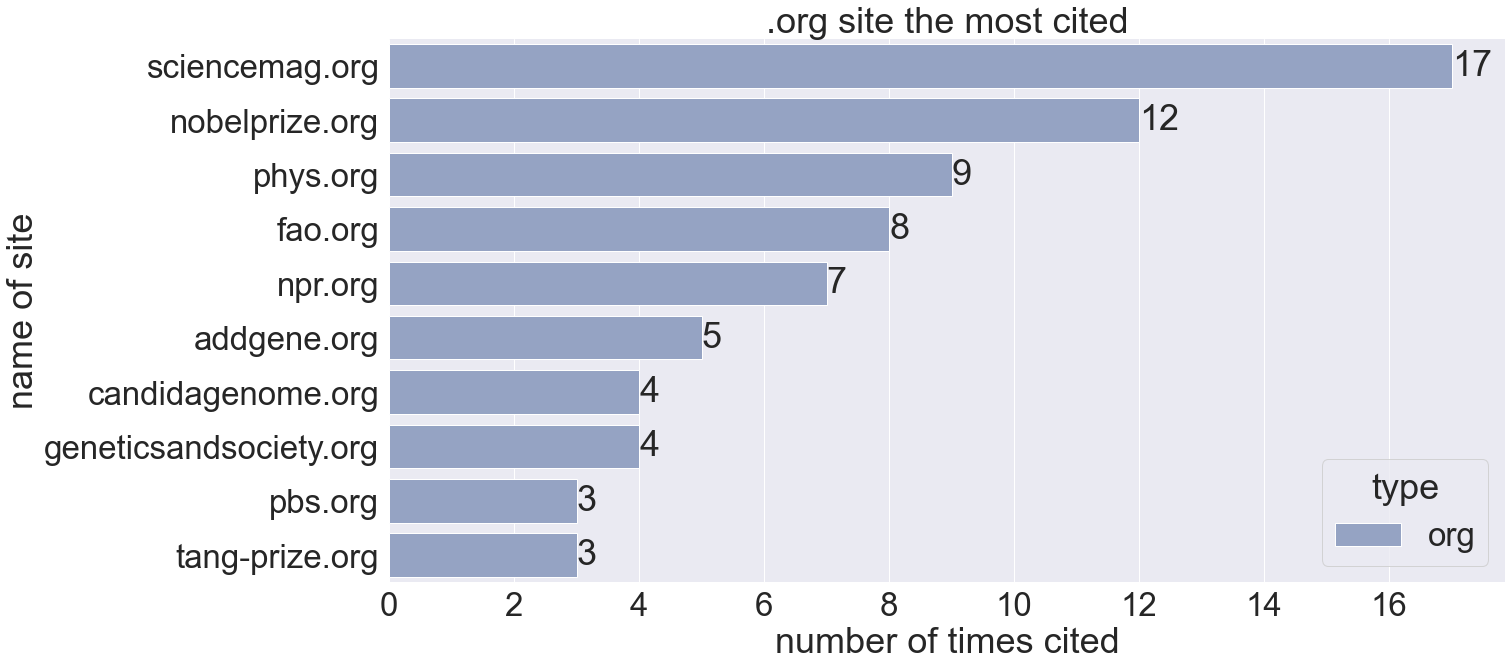

In [130]:
#An example of the plot for .org citation
dorg,dico=sortcitation(df.loc[:,"citationorgtext"],"org")    
print(dorg)
plot_site_most_cited(dorg,10,".org site the most cited")

44


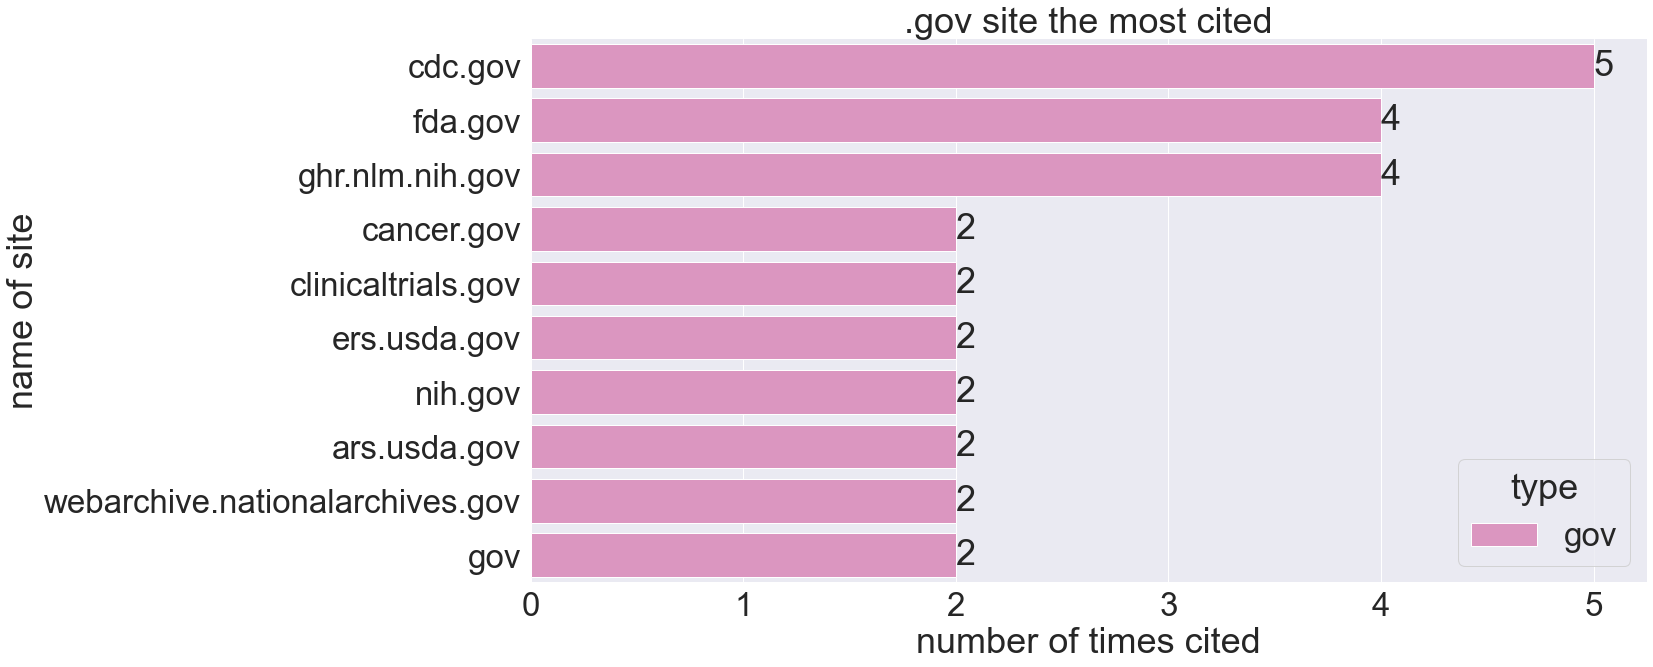

In [131]:
dfgov,j=sortcitation(df.loc[:,"citationgovtext"],"gov")

plot_site_most_cited(dfgov,10,".gov site the most cited")

2026


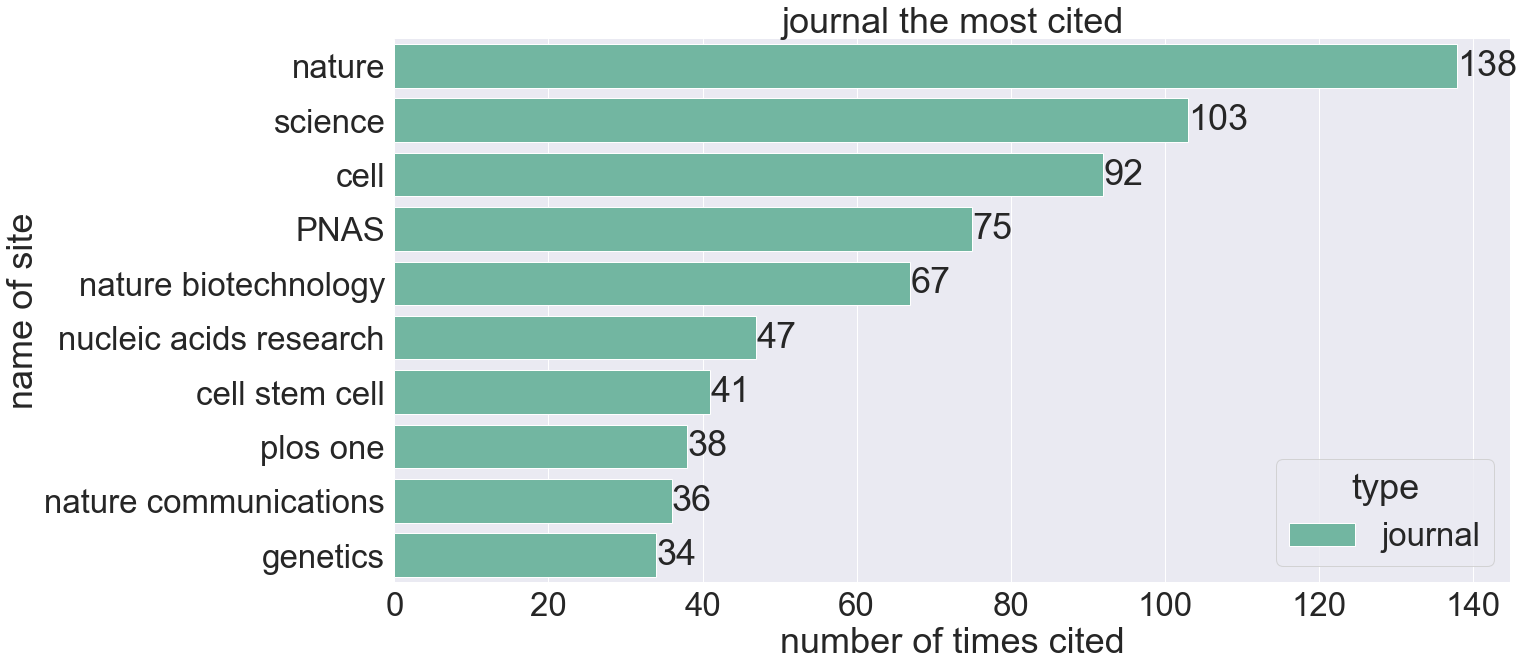

In [132]:
dfsci,j=sortcitation(df.loc[:,"journal"],"journal")
plot_site_most_cited(dfsci,10, "journal the most cited")

361


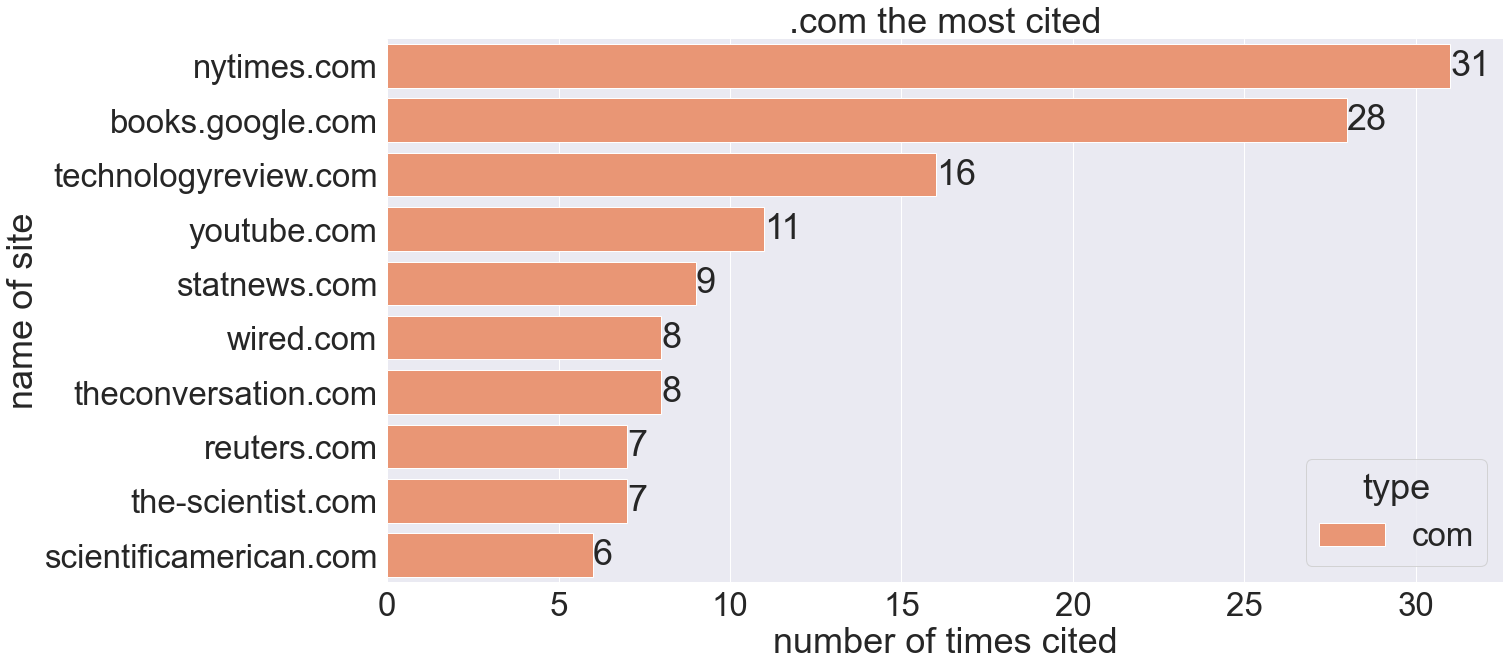

In [133]:
dcom,bl=sortcitation(df.loc[:,"citationcomtext"],"com")
plot_site_most_cited(dcom,10, ".com the most cited")

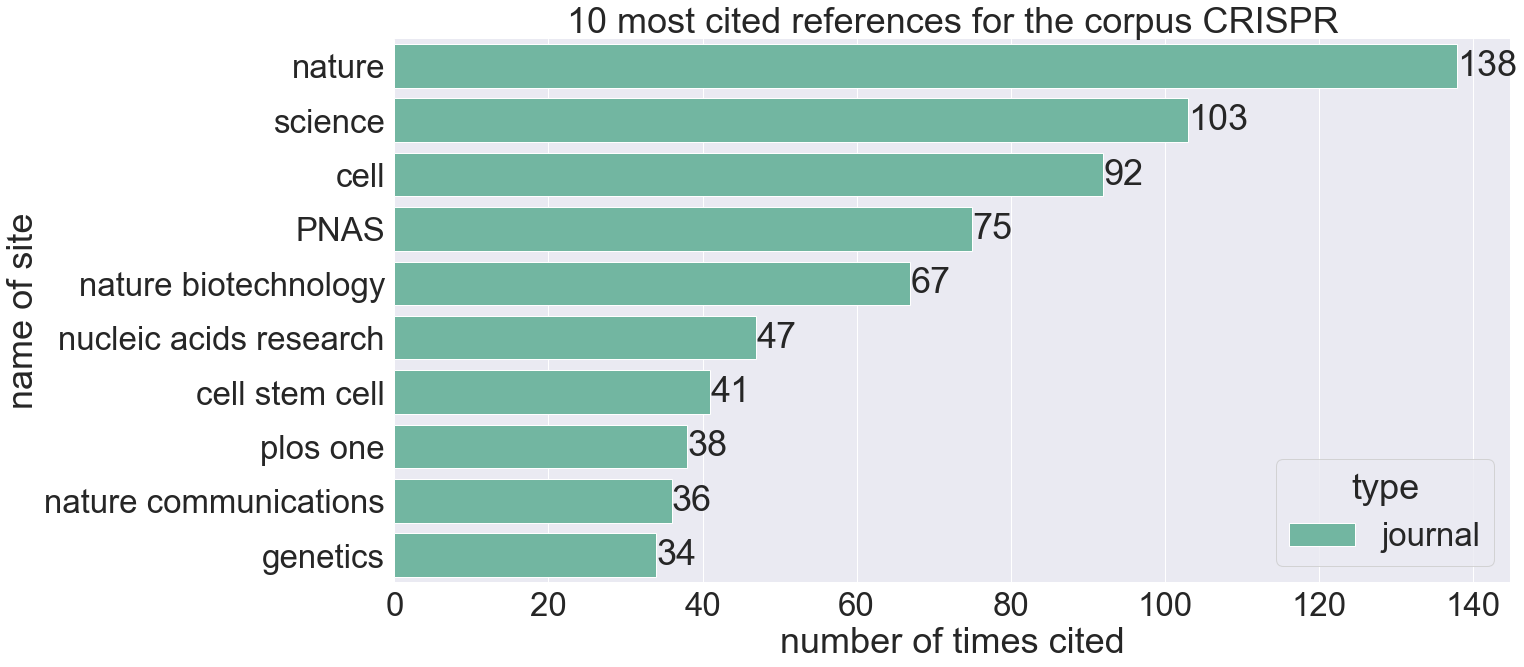

In [134]:
dIg={"name of site": ["IPCC","theguardian"], "number of times cited":[df.loc[:,"citation IPCC"].sum(), df.loc[:,"citationguardian"].sum()], "type": ["IPCC","com"]}
dIg = pd.DataFrame.from_dict(dIg)
big_df = pd.concat([dorg, dfgov,dcom,dfsci,dIg], ignore_index=True)
big_df.sort_values(by=['number of times cited'], inplace=True, ascending=False)
plot_site_most_cited(big_df,10,"10 most cited references for the corpus CRISPR")

## Cleaning the column and exporting the data frame and scrap of page information

In [41]:
titlelist=df["Name only"].tolist() #make a list will all titles
#We need to recreate the wiki url, first step is to get rid of blanks
titleunderscore = [sub.replace(' ', '_') for sub in titlelist]

In [42]:
#We finally get from the original url to the pageinfo url
urlmodifié = ['https://en.wikipedia.org/w/index.php?title=' + i +'&action=info' for i in titleunderscore]

In [43]:
#Cell to scrap infos from "page info" section (2 to scrap the third table of the page)
doblist=[]
creatorlist=[]
totaledits=[]
recentedits=[]
pageid=[]
pagelenght=[]
editprotection=[]
recentpageviews=[]

for i in tqdm(urlmodifié) :
    source = requests.get(i)
    soup = BeautifulSoup(source.text, 'lxml')
    alltables=soup.findAll('table', {"class": "wikitable mw-page-info"})
    tableau_html_liste=pd.read_html(str(alltables)) #We get it as a list   
    df_pageinfo2=pd.DataFrame(tableau_html_liste[2]) #And make it a df 
    #The number between brackets corresponds to the number of the table according to its order on the html page
    creatorlist += [df_pageinfo2.iat[0, 1]]
    doblist += [df_pageinfo2.iat[1, 1]]
    totaledits += [df_pageinfo2.iat[4, 1]]
    recentedits += [df_pageinfo2.iat[5, 1]]
    
    
    #Scrap of the first table of the page (0)
    df_pageinfo0=pd.DataFrame(tableau_html_liste[0])
    pagelenght += [df_pageinfo0.iat[2, 1]]
    pageid += [df_pageinfo0.iat[3, 1]]
            
    
    #Scrap of the second table of the page (1)
    df_pageinfo1=pd.DataFrame(tableau_html_liste[1])
    editprotection += [df_pageinfo1.iat[1, 1]]
  

    

100%|████████████████████████████████████████████████████████████████████████████████| 684/684 [09:51<00:00,  1.16it/s]


In [47]:
#Cell to add the new lists as new columns of the df
df["Page id"]=pageid
df["Edit protection"]=editprotection
df["Page lenght (Bytes)"]=pagelenght
df["DOB"]=doblist
df["Creator"]=creatorlist
df["Total edits"]=totaledits
df["Recent edits"]=recentedits
df.head()

,Unnamed: 0,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,journal,citation org,...,Edit protection,Page lenght (Bytes),DOB,Total edits,Recent edits,Formated DOB,Year_month,Year,number of article created by creator,Creator
Creator,,,,,,,,,,,,,,,,,,,,,
Peter Isotalo,0,Medieval cuisine,https://en.wikipedia.org/wiki/Medieval_cuisine,"{{Short description|Foods, eating habits, and ...","{'Ref count': 124, 'nb_journal_citations': 3, ...",124,3,"[10.1484/j.abol.5.102054, 10.1007/s00586-007-0...","[[analecta bollandiana], [eur spine j]]",0,...,Allow all users (no expiry set),101475,"12:41, 17 September 2006",2287,2,2006-09-17,2006-09,2006,1,Peter Isotalo (talk | contribs)
128.206.58.214,1,Arab cuisine,https://en.wikipedia.org/wiki/Arab_cuisine,{{Short description|Cuisine of Arab people}}\n...,"{'Ref count': 28, 'nb_journal_citations': 0, '...",28,0,[],[],1,...,Allow all users (no expiry set),47418,"21:18, 15 June 2005",1541,1,2005-06-15,2005-06,2005,1,128.206.58.214 (talk)
Peter Isotalo,2,Regional cuisines of medieval Europe,https://en.wikipedia.org/wiki/Regional_cuisine...,The '''regional cuisines of medieval Europe'''...,"{'Ref count': 19, 'nb_journal_citations': 1, '...",19,1,"[10.2307/2598138, None, None]",[[the economic history review]],0,...,Allow all users (no expiry set),30834,"23:28, 1 March 2007",161,0,2007-03-01,2007-03,2007,1,Peter Isotalo (talk | contribs)
Mkweise,3,European cuisine,https://en.wikipedia.org/wiki/European_cuisine,{{Short description|Cuisine indigenous to Euro...,"{'Ref count': 12, 'nb_journal_citations': 0, '...",12,0,[],[],1,...,Allow all users (no expiry set),26333,"23:44, 13 March 2004",1695,23,2004-03-13,2004-03,2004,1,Mkweise (talk | contribs)
142.177.97.12,4,List of cuisines,https://en.wikipedia.org/wiki/List_of_cuisines,{{Short description|None}}\n{{Use dmy dates|da...,"{'Ref count': 4, 'nb_journal_citations': 0, 'c...",4,0,[],[],0,...,Allow all users (no expiry set),24388,"18:17, 11 July 2003",1156,2,2003-07-11,2003-07,2003,1,142.177.97.12 (talk)


In [48]:
#Cleaning the table

#Getting rid of the time
df["DOB"]= df["DOB"].str.slice(7,100,1) 
#peutêtre qu'on pourrait mettre comme end point la len de la string

#Format the date
df["Formated DOB"]=pd.to_datetime(df["DOB"], format='%d %B %Y')
df["Year_month"]= pd.to_datetime(df['DOB']).dt.to_period('M')

#Getting the year
df['Year'] = pd.DatetimeIndex(df['DOB']).year

#Cleaning the creator 
df["Creator"]= df["Creator"].str.replace(r"\(.*\)",'', regex=True)

#### Plot the ratio of page created by a certain editor in our corpus

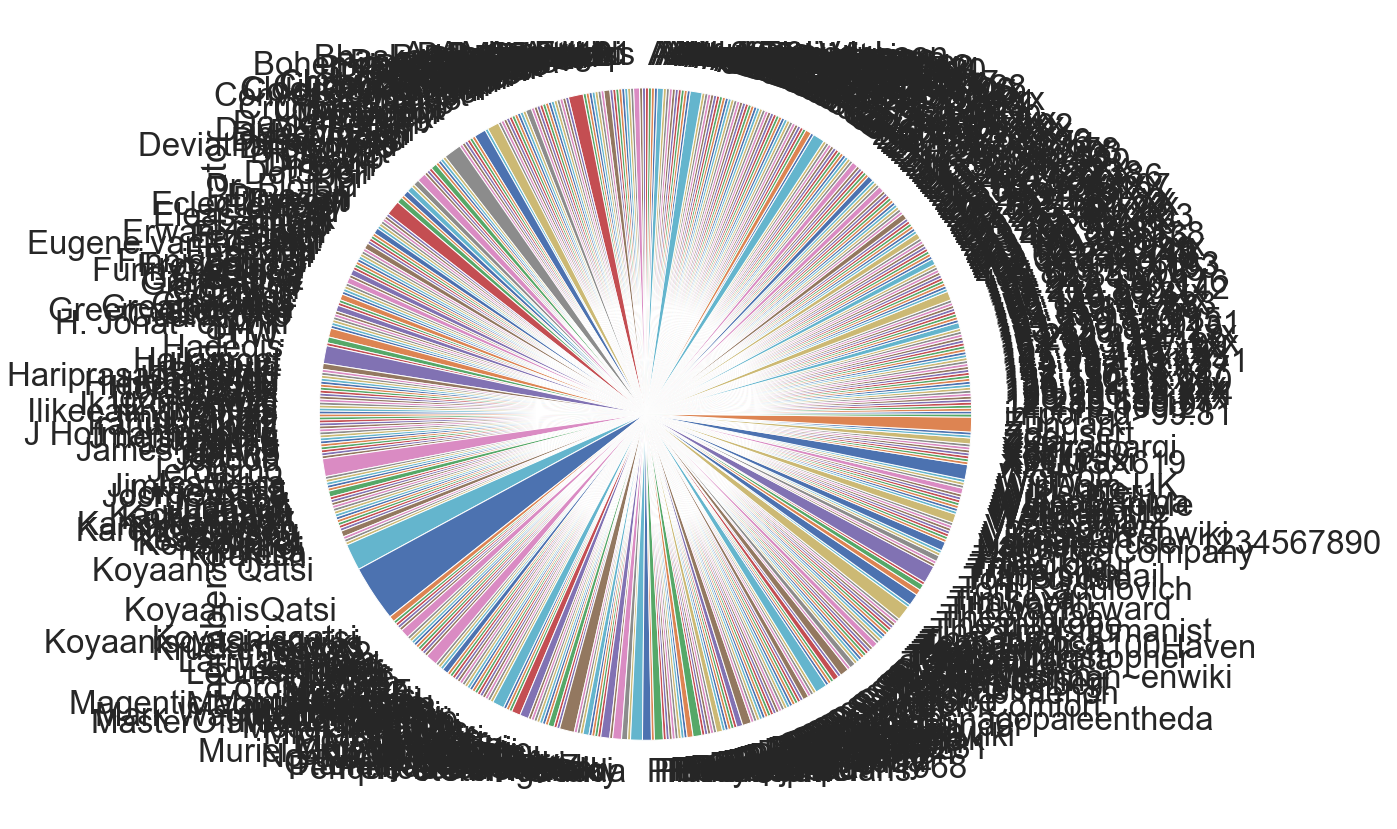

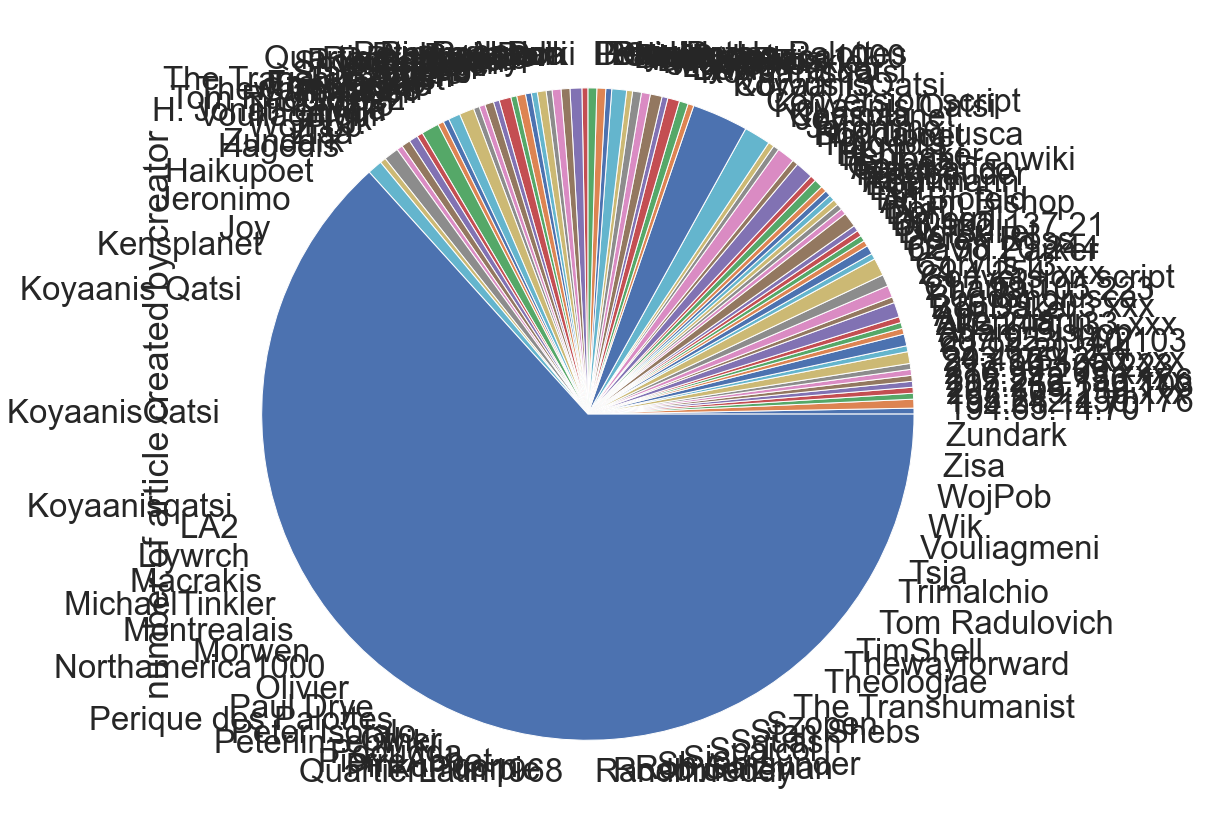

,Unnamed: 0,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,journal,citation org,...,Page id,Edit protection,Page lenght (Bytes),DOB,Total edits,Recent edits,Formated DOB,Year_month,Year,number of article created by creator
Creator,,,,,,,,,,,,,,,,,,,,,
Peter Isotalo,0,Medieval cuisine,https://en.wikipedia.org/wiki/Medieval_cuisine,"{{Short description|Foods, eating habits, and ...","{'Ref count': 124, 'nb_journal_citations': 3, ...",124,3,"[10.1484/j.abol.5.102054, 10.1007/s00586-007-0...","[[analecta bollandiana], [eur spine j]]",0,...,7029997,Allow all users (no expiry set),101475,17 September 2006,2287,2,2006-09-17,2006-09,2006,1
128.206.58.214,1,Arab cuisine,https://en.wikipedia.org/wiki/Arab_cuisine,{{Short description|Cuisine of Arab people}}\n...,"{'Ref count': 28, 'nb_journal_citations': 0, '...",28,0,[],[],1,...,2053043,Allow all users (no expiry set),47418,15 June 2005,1541,1,2005-06-15,2005-06,2005,1
Peter Isotalo,2,Regional cuisines of medieval Europe,https://en.wikipedia.org/wiki/Regional_cuisine...,The '''regional cuisines of medieval Europe'''...,"{'Ref count': 19, 'nb_journal_citations': 1, '...",19,1,"[10.2307/2598138, None, None]",[[the economic history review]],0,...,9798488,Allow all users (no expiry set),30834,1 March 2007,161,0,2007-03-01,2007-03,2007,1
Mkweise,3,European cuisine,https://en.wikipedia.org/wiki/European_cuisine,{{Short description|Cuisine indigenous to Euro...,"{'Ref count': 12, 'nb_journal_citations': 0, '...",12,0,[],[],1,...,524762,Allow all users (no expiry set),26333,13 March 2004,1695,23,2004-03-13,2004-03,2004,1
142.177.97.12,4,List of cuisines,https://en.wikipedia.org/wiki/List_of_cuisines,{{Short description|None}}\n{{Use dmy dates|da...,"{'Ref count': 4, 'nb_journal_citations': 0, 'c...",4,0,[],[],0,...,265366,Allow all users (no expiry set),24388,11 July 2003,1156,2,2003-07-11,2003-07,2003,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PolishPoliticians,679,Kępno,https://en.wikipedia.org/wiki/K%C4%99pno,{{other places|Kępno (disambiguation)}}\n{{Inf...,"{'Ref count': 10, 'nb_journal_citations': 0, '...",10,0,[],[],0,...,829399,Allow all users (no expiry set),11263,16 July 2004,122,1,2004-07-16,2004-07,2004,1
80.58.48.170,680,Mundaka,https://en.wikipedia.org/wiki/Mundaka,{{use dmy dates|date=October 2015}}\n{{Infobox...,"{'Ref count': 0, 'nb_journal_citations': 0, 'c...",0,0,[],[],0,...,2883015,Allow all users (no expiry set),17281,11 October 2005,162,1,2005-10-11,2005-10,2005,1
Magentic Manifestations,681,Culture of Coimbatore,https://en.wikipedia.org/wiki/Culture_of_Coimb...,{{Use dmy dates|date=February 2018}}\n{{Use In...,"{'Ref count': 29, 'nb_journal_citations': 0, '...",29,0,[],[],1,...,46250566,Allow all users (no expiry set),16500,28 March 2015,68,3,2015-03-28,2015-03,2015,1


In [49]:
#creation of a new dataframe
dfbis=df

dfbis["number of article created by creator"]=1
dfbis.set_index("Creator",inplace=True)
dfbis=dfbis.groupby("Creator")["number of article created by creator"].sum()

fig = plt.figure(0,figsize=(20,15))
dfbis.plot.pie(subplots=True)
fig.savefig('article_created_by_creator.jpg', bbox_inches='tight', dpi=150)

fig2 = plt.figure(1,figsize=(20,15))
dfwithoutother=dfbis[dfbis>1]
dfwithoutother.plot.pie(subplots=True)

dftris=dfbis[dfbis==1].sum()
dfbis.loc["Other"]=dftris


fig3 = plt.figure(1,figsize=(20,15))
dfbis[dfbis>1].plot.pie(subplots=True)
fig2.savefig('article_created_by_important_creator.jpg', bbox_inches='tight', dpi=150)

plt.show()
df

#### plot of the timeline

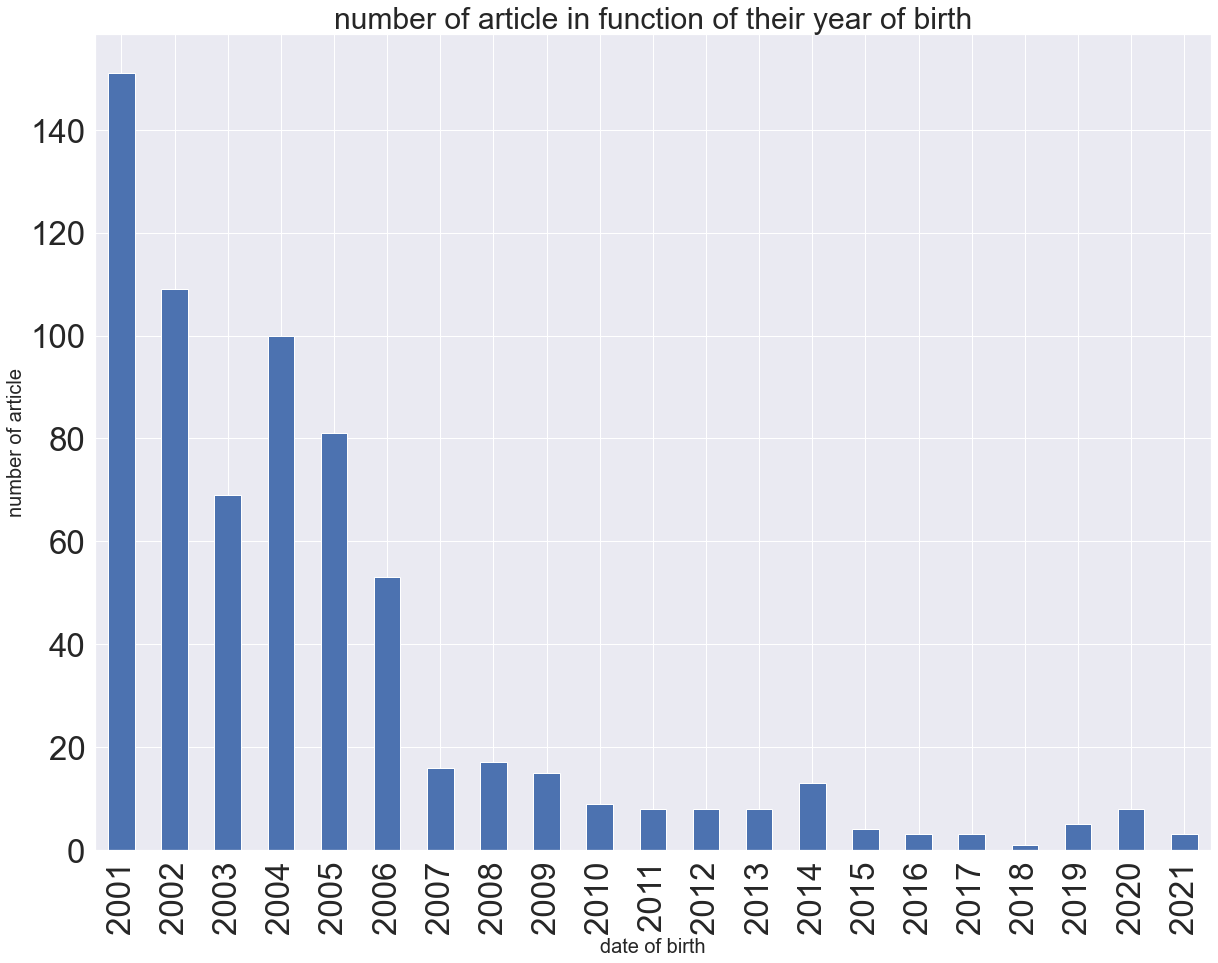

In [50]:
fig = plt.figure(0,figsize=(20,15))
plothist=df["Year"].value_counts().sort_index().plot(kind="bar")
fig.savefig('timeline.jpg', bbox_inches='tight', dpi=150)
plt.xlabel('date of birth',fontsize = 20) 
plt.ylabel('number of article',fontsize = 20) 
plt.title("number of article in function of their year of birth",fontsize = 30)
plt.show()

#### Clean and export the dataframes to csv

In [258]:
del df['citationorgtext']
del df['citationgovtext']
del df['text']
del df["citations"]
del df["citationcomtext"]

In [49]:
#extract the data frame to csv
df.to_csv('climatechange‧csv')
dforg.to_csv('climatechangeorg.csv')
dfgov.to_csv('climatechangegov.csv')
dcom.to_csv('climatechangecom.csv')

"\ndfgov.to_csv('climatechangegov.csv')\ndcom.to_csv('climatechangecom.csv')"